## Trading Simulation Analysis

The code below uses different functions to visualize and analyze trade data for the 3 trading strategies developed. Additionally, we also import farma-french factors data available from Ken French's website and set the date column as the index to determine correlations / regression analyses using market factors. 

### Imports

In [104]:
import os
import quandl
import zipfile
import datetime
import warnings
import scipy as sp
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from statsmodels.tsa.stattools import adfuller

### Define Helper Functions

In [165]:
def performance_summary(cumulative_pl):
    """
    Returns the Performance Stats for a given set of data.
    
    Inputs: 
        data - DataFrame with Date index and corresponding financial data.
    
    Output:
        summary_stats - DataFrame with summary statistics.
    """
    daily_returns = cumulative_pl
    
    summary_stats = pd.DataFrame()
    summary_stats['Mean'] = daily_returns.mean()
    summary_stats['Median'] = daily_returns.median()
    summary_stats['Volatility'] = daily_returns.std() 
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']
    summary_stats['Skewness'] = daily_returns.skew()
    summary_stats['Excess Kurtosis'] = daily_returns.kurtosis()
    summary_stats['Min'] = daily_returns.min()
    summary_stats['Max'] = daily_returns.max()

    wealth_index = 1000 * (1 + daily_returns)
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    
    return summary_stats

In [51]:
def plot_trades_over_time(*cumulative_pls):
    """
    Plots gross option trades and gross stock trades over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data including
                         gross_option_trades and gross_stock_trades.
    """
    fig, axs = plt.subplots(2, len(cumulative_pls), figsize=(12 * len(cumulative_pls), 8))  

    for i, cumulative_pl in enumerate(cumulative_pls):
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['gross_option_trades'], color='blue', marker='o', linestyle='-')
        axs[0, i].set_title(f'Gross Option Trades Over Time: Strategy {i+1}')  
        axs[0, i].set_xlabel('Date')  # X-axis label
        axs[0, i].set_ylabel('Gross Option Trades')  
        axs[0, i].grid(True)  

        axs[1, i].plot(cumulative_pl.index, cumulative_pl['gross_stock_trades'], color='red', marker='o', linestyle='-')
        axs[1, i].set_title(f'Gross Stock Trades Over Time: Strategy {i+1}')  
        axs[1, i].set_xlabel('Date')  
        axs[1, i].set_ylabel('Gross Stock Trades')  
        axs[1, i].grid(True)  

    plt.tight_layout()
    plt.show()

In [54]:
def plot_position_values_over_time(*cumulative_pls):
    """
    Plots option position value and stock position value over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data including
                         option_pos_value and stock_pos_value.
    """
    # Determine the number of trading strategies (dataframes)
    num_strategies = len(cumulative_pls)
    fig, axs = plt.subplots(2, num_strategies, figsize=(12 * num_strategies, 8), squeeze=False)  

    for i, cumulative_pl in enumerate(cumulative_pls):
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['option_pos_value'], color='green', marker='o', linestyle='-')
        axs[0, i].set_title(f'Option Position Value Over Time: Strategy {i+1}')  
        axs[0, i].set_xlabel('Date')  # X-axis label
        axs[0, i].set_ylabel('Option Position Value ($)')  
        axs[0, i].grid(True)  

        axs[1, i].plot(cumulative_pl.index, cumulative_pl['stock_pos_value'], color='purple', marker='o', linestyle='-')
        axs[1, i].set_title(f'Stock Position Value Over Time: Strategy {i+1}')  
        axs[1, i].set_xlabel('Date')  
        axs[1, i].set_ylabel('Stock Position Value ($)')  
        axs[1, i].grid(True)  

    plt.tight_layout()
    plt.show()

In [144]:
def plot_trading_costs_over_time(*cumulative_pls):
    """
    Plots stock trading costs, option trading costs, and net trading costs over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data including
                         stock_trading_costs, option_trading_costs, and net_trading_costs.
    """
    # Determine the number of trading strategies (dataframes)
    num_strategies = len(cumulative_pls)
    fig, axs = plt.subplots(3, num_strategies, figsize=(12 * num_strategies, 12), squeeze=False)  # Adjust for three rows

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Plot stock trading costs
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['stock_trading_costs'], color='blue', marker='o', linestyle='-')
        axs[0, i].set_title(f'Stock Trading Costs Over Time: Strategy {i+1}')  
        axs[0, i].set_xlabel('Date')  
        axs[0, i].set_ylabel('Stock Trading Costs ($)')  
        axs[0, i].grid(True)  

        # Plot option trading costs
        axs[1, i].plot(cumulative_pl.index, cumulative_pl['option_trading_costs'], color='red', marker='o', linestyle='-')
        axs[1, i].set_title(f'Option Trading Costs Over Time: Strategy {i+1}')  
        axs[1, i].set_xlabel('Date')  
        axs[1, i].set_ylabel('Option Trading Costs ($)')  
        axs[1, i].grid(True)

        # Plot net trading costs
        axs[2, i].plot(cumulative_pl.index, cumulative_pl['net_trading_costs'], color='green', marker='o', linestyle='-')
        axs[2, i].set_title(f'Net Trading Costs Over Time: Strategy {i+1}')  
        axs[2, i].set_xlabel('Date')  
        axs[2, i].set_ylabel('Net Trading Costs ($)')  
        axs[2, i].grid(True)  

    plt.tight_layout()
    plt.show()

In [57]:
def plot_pl_over_time(*cumulative_pls):
    """
    Plots option, stock, and net P&L values over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data.
    """
    # Determine the number of trading strategies (dataframes)
    num_strategies = len(cumulative_pls)
    fig, axs = plt.subplots(3, num_strategies, figsize=(12 * num_strategies, 12), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['daily_option_PL'], color='orange', marker='o', linestyle='-')
        axs[0, i].set_title(f'Option P&L Over Time: Strategy {i+1}')
        axs[0, i].set_xlabel('Date')
        axs[0, i].set_ylabel('Option P&L ($)')
        axs[0, i].grid(True)
        
        axs[1, i].plot(cumulative_pl.index, cumulative_pl['daily_stock_PL'], color='cyan', marker='o', linestyle='-')
        axs[1, i].set_title(f'Stock P&L Over Time: Strategy {i+1}')
        axs[1, i].set_xlabel('Date')
        axs[1, i].set_ylabel('Stock P&L ($)')
        axs[1, i].grid(True)
        
        axs[2, i].plot(cumulative_pl.index, cumulative_pl['daily_net_PL'], color='magenta', marker='o', linestyle='-')
        axs[2, i].set_title(f'Net P&L Over Time: Strategy {i+1}')
        axs[2, i].set_xlabel('Date')
        axs[2, i].set_ylabel('Net P&L ($)')
        axs[2, i].grid(True)

    plt.tight_layout()
    plt.show()

In [61]:
def plot_cumulative_pl_over_time(*cumulative_pls):
    """
    Plots cumulative option, stock, and net P&L values over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data.
    """
    # Determine the number of trading strategies (dataframes)
    num_strategies = len(cumulative_pls)
    fig, axs = plt.subplots(3, num_strategies, figsize=(12 * num_strategies, 12), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['option_PL'], color='orange', marker='o', linestyle='-')
        axs[0, i].set_title(f'Cumulative Option P&L Over Time: Strategy {i+1}')
        axs[0, i].set_xlabel('Date')
        axs[0, i].set_ylabel('Cumulative Option P&L ($)')
        axs[0, i].grid(True)
        
        axs[1, i].plot(cumulative_pl.index, cumulative_pl['stock_PL'], color='cyan', marker='o', linestyle='-')
        axs[1, i].set_title(f'Cumulative Stock P&L Over Time: Strategy {i+1}')
        axs[1, i].set_xlabel('Date')
        axs[1, i].set_ylabel('Cumulative Stock P&L ($)')
        axs[1, i].grid(True)
        
        axs[2, i].plot(cumulative_pl.index, cumulative_pl['net_PL'], color='magenta', marker='o', linestyle='-')
        axs[2, i].set_title(f'Cumulative Net P&L Over Time: Strategy {i+1}')
        axs[2, i].set_xlabel('Date')
        axs[2, i].set_ylabel('Cumulative Net P&L ($)')
        axs[2, i].grid(True)

    plt.tight_layout()
    plt.show()

In [146]:
def plot_kapital_over_time(*cumulative_pls):
    """
    Plots initial capital and end capital over time for multiple trading strategies.
    
    Inputs:
        cumulative_pls - Tuple of DataFrames, each with Date index and financial data including
                         initial_kapital and end_kapital.
    """
    # Determine the number of trading strategies (dataframes)
    num_strategies = len(cumulative_pls)
    fig, axs = plt.subplots(2, num_strategies, figsize=(12 * num_strategies, 8), squeeze=False)  # Adjust for two rows

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Plot initial capital
        axs[0, i].plot(cumulative_pl.index, cumulative_pl['initial_kapital'], color='blue', marker='o', linestyle='-')
        axs[0, i].set_title(f'Initial Capital Over Time: Strategy {i+1}')  
        axs[0, i].set_xlabel('Date')  
        axs[0, i].set_ylabel('Initial Capital ($)')  
        axs[0, i].grid(True)  

        # Plot end capital
        axs[1, i].plot(cumulative_pl.index, cumulative_pl['end_kapital'], color='red', marker='o', linestyle='-')
        axs[1, i].set_title(f'End Capital Over Time: Strategy {i+1}')  
        axs[1, i].set_xlabel('Date')  
        axs[1, i].set_ylabel('End Capital ($)')  
        axs[1, i].grid(True)

    plt.tight_layout()
    plt.show()

In [66]:
def plot_trades_and_test_stationarity(*cumulative_pls):
    """
    This function creates subplots for 'gross_option_trades' and 'gross_stock_trades' from multiple 'cumulative_pl' DataFrames.
    It plots the original data along with their 5-day, 30-day, and 100-day rolling averages for each trading strategy.
    Additionally, it performs the Augmented Dickey-Fuller (ADF) test on both datasets to test for stationarity and 
    displays the test results (Test Statistic and P-Value) below each subplot.

    Inputs:
        cumulative_pls - Tuple of DataFrames with columns including 'gross_option_trades' and 'gross_stock_trades'.
    """
    num_strategies = len(cumulative_pls)
    fig, axes = plt.subplots(2, num_strategies, figsize=(20, 10), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Plot for gross_option_trades
        axes[0, i].plot(cumulative_pl['gross_option_trades'], label="Gross Option Trades")
        axes[0, i].plot(cumulative_pl['gross_option_trades'].rolling(5).mean(), label="5-day MA")
        axes[0, i].plot(cumulative_pl['gross_option_trades'].rolling(30).mean(), label="30-day MA")
        axes[0, i].plot(cumulative_pl['gross_option_trades'].rolling(100).mean(), label="100-day MA")
        axes[0, i].set_title(f"Strategy {i+1}: Gross Option Trades", fontsize=18)
        axes[0, i].legend(fontsize=14)

        # ADF test on gross_option_trades
        adf_result_option = adfuller(cumulative_pl['gross_option_trades'].dropna(), maxlag=1)
        axes[0, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_option[0]:.2f}\nP-Value: {adf_result_option[1]:.4f}', 
                        transform=axes[0, i].transAxes, fontsize=14)

        # Plot for gross_stock_trades
        axes[1, i].plot(cumulative_pl['gross_stock_trades'], label="Gross Stock Trades")
        axes[1, i].plot(cumulative_pl['gross_stock_trades'].rolling(5).mean(), label="5-day MA")
        axes[1, i].plot(cumulative_pl['gross_stock_trades'].rolling(30).mean(), label="30-day MA")
        axes[1, i].plot(cumulative_pl['gross_stock_trades'].rolling(100).mean(), label="100-day MA")
        axes[1, i].set_title(f"Strategy {i+1}: Gross Stock Trades", fontsize=18)
        axes[1, i].legend(fontsize=14)

        # ADF test on gross_stock_trades
        adf_result_stock = adfuller(cumulative_pl['gross_stock_trades'].dropna(), maxlag=1)
        axes[1, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_stock[0]:.2f}\nP-Value: {adf_result_stock[1]:.4f}', 
                        transform=axes[1, i].transAxes, fontsize=14)

    plt.tight_layout()
    plt.show()

In [68]:
def plot_position_values_and_test_stationarity(*cumulative_pls):
    """
    This function creates subplots for 'option_pos_value' and 'stock_pos_value' from multiple 'cumulative_pl' DataFrames.
    It plots the original data along with their 5-day, 30-day, and 100-day rolling averages for each trading strategy.
    Additionally, it performs the Augmented Dickey-Fuller (ADF) test on both datasets to test for stationarity and 
    displays the test results (Test Statistic and P-Value) below each subplot.

    Inputs:
        cumulative_pls - Tuple of DataFrames with columns including 'option_pos_value' and 'stock_pos_value'.
    """
    num_strategies = len(cumulative_pls)
    fig, axes = plt.subplots(2, num_strategies, figsize=(20 * num_strategies, 10), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Plot for option_pos_value
        axes[0, i].plot(cumulative_pl['option_pos_value'], label="Option Position Value")
        axes[0, i].plot(cumulative_pl['option_pos_value'].rolling(5).mean(), label="5-day MA")
        axes[0, i].plot(cumulative_pl['option_pos_value'].rolling(30).mean(), label="30-day MA")
        axes[0, i].plot(cumulative_pl['option_pos_value'].rolling(100).mean(), label="100-day MA")
        axes[0, i].set_title(f"Strategy {i+1}: Option Position Value", fontsize=18)
        axes[0, i].legend(fontsize=14)

        # Perform and display ADF test results for option_pos_value
        adf_result_option = adfuller(cumulative_pl['option_pos_value'].dropna(), maxlag=1)
        axes[0, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_option[0]:.2f}\nP-Value: {adf_result_option[1]:.4f}', 
                        transform=axes[0, i].transAxes, fontsize=14)

        # Plot for stock_pos_value
        axes[1, i].plot(cumulative_pl['stock_pos_value'], label="Stock Position Value")
        axes[1, i].plot(cumulative_pl['stock_pos_value'].rolling(5).mean(), label="5-day MA")
        axes[1, i].plot(cumulative_pl['stock_pos_value'].rolling(30).mean(), label="30-day MA")
        axes[1, i].plot(cumulative_pl['stock_pos_value'].rolling(100).mean(), label="100-day MA")
        axes[1, i].set_title(f"Strategy {i+1}: Stock Position Value", fontsize=18)
        axes[1, i].legend(fontsize=14)

        # Perform and display ADF test results for stock_pos_value
        adf_result_stock = adfuller(cumulative_pl['stock_pos_value'].dropna(), maxlag=1)
        axes[1, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_stock[0]:.2f}\nP-Value: {adf_result_stock[1]:.4f}', 
                        transform=axes[1, i].transAxes, fontsize=14)

    plt.tight_layout()
    plt.show()

In [71]:
def plot_pl_values_and_test_stationarity(*cumulative_pls):
    """
    This function creates subplots for 'daily_option_PL', 'daily_stock_PL', and 'daily_net_PL' from multiple 'cumulative_pl' DataFrames.
    It plots the original data along with their 5-day, 30-day, and 100-day rolling averages for each trading strategy.
    Additionally, it performs the Augmented Dickey-Fuller (ADF) test on all three datasets to test for stationarity and 
    displays the test results (Test Statistic and P-Value) below each subplot.

    Inputs:
        cumulative_pls - Tuple of DataFrames with columns including 'daily_option_PL', 'daily_stock_PL', and 'daily_net_PL'.
    """
    num_strategies = len(cumulative_pls)
    fig, axes = plt.subplots(3, num_strategies, figsize=(20 * num_strategies, 15), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Plot for daily_option_PL
        axes[0, i].plot(cumulative_pl['daily_option_PL'], label="Daily Option P&L")
        axes[0, i].plot(cumulative_pl['daily_option_PL'].rolling(5).mean(), label="5-day MA")
        axes[0, i].plot(cumulative_pl['daily_option_PL'].rolling(30).mean(), label="30-day MA")
        axes[0, i].plot(cumulative_pl['daily_option_PL'].rolling(100).mean(), label="100-day MA")
        axes[0, i].set_title(f"Strategy {i+1}: Option P&L", fontsize=18)
        axes[0, i].legend(fontsize=14)

        # Perform and display ADF test results for daily_option_PL
        adf_result_option = adfuller(cumulative_pl['daily_option_PL'].dropna(), maxlag=1)
        axes[0, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_option[0]:.2f}\nP-Value: {adf_result_option[1]:.4f}', 
                        transform=axes[0, i].transAxes, fontsize=14)

        # Plot for daily_stock_PL
        axes[1, i].plot(cumulative_pl['daily_stock_PL'], label="Daily Stock P&L")
        axes[1, i].plot(cumulative_pl['daily_stock_PL'].rolling(5).mean(), label="5-day MA")
        axes[1, i].plot(cumulative_pl['daily_stock_PL'].rolling(30).mean(), label="30-day MA")
        axes[1, i].plot(cumulative_pl['daily_stock_PL'].rolling(100).mean(), label="100-day MA")
        axes[1, i].set_title(f"Strategy {i+1}: Stock P&L", fontsize=18)
        axes[1, i].legend(fontsize=14)

        # Perform and display ADF test results for daily_stock_PL
        adf_result_stock = adfuller(cumulative_pl['daily_stock_PL'].dropna(), maxlag=1)
        axes[1, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_stock[0]:.2f}\nP-Value: {adf_result_stock[1]:.4f}', 
                        transform=axes[1, i].transAxes, fontsize=14)

        # Plot for daily_net_PL
        axes[2, i].plot(cumulative_pl['daily_net_PL'], label="Daily Net P&L")
        axes[2, i].plot(cumulative_pl['daily_net_PL'].rolling(5).mean(), label="5-day MA")
        axes[2, i].plot(cumulative_pl['daily_net_PL'].rolling(30).mean(), label="30-day MA")
        axes[2, i].plot(cumulative_pl['daily_net_PL'].rolling(100).mean(), label="100-day MA")
        axes[2, i].set_title(f"Strategy {i+1}: Net P&L", fontsize=18)
        axes[2, i].legend(fontsize=14)

        # Perform and display ADF test results for daily_net_PL
        adf_result_net = adfuller(cumulative_pl['daily_net_PL'].dropna(), maxlag=1)
        axes[2, i].text(0.01, -0.3, f'ADF Statistic: {adf_result_net[0]:.2f}\nP-Value: {adf_result_net[1]:.4f}', 
                        transform=axes[2, i].transAxes, fontsize=14)

    plt.tight_layout()
    plt.show()

In [73]:
def plot_correlations(*cumulative_pls):
    """
    Creates subplots for each trading strategy, each displaying the correlation between two specific variables:
    1. Gross option trades vs. gross stock trades
    2. Option position value vs. stock position value
    3. Option P&L vs. Stock P&L

    Inputs:
        cumulative_pls - Tuple of DataFrames with required financial columns.
    """
    num_strategies = len(cumulative_pls)
    fig, axes = plt.subplots(3, num_strategies, figsize=(8 * num_strategies, 15), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        # Correlation and plot for gross_option_trades and gross_stock_trades
        correlation1 = cumulative_pl['gross_option_trades'].corr(cumulative_pl['gross_stock_trades'])
        axes[0, i].scatter(cumulative_pl['gross_option_trades'], cumulative_pl['gross_stock_trades'],
                           label=f'Correlation: {correlation1:.2f}', color='blue', alpha=0.7)
        axes[0, i].set_xlabel('Gross Option Trades')
        axes[0, i].set_ylabel('Gross Stock Trades')
        axes[0, i].set_title(f'Strategy {i+1}: Gross Option vs. Stock Trades')
        axes[0, i].legend()
        axes[0, i].grid(True)

        # Correlation and plot for option_pos_value and stock_pos_value
        correlation2 = cumulative_pl['option_pos_value'].corr(cumulative_pl['stock_pos_value'])
        axes[1, i].scatter(cumulative_pl['option_pos_value'], cumulative_pl['stock_pos_value'],
                           label=f'Correlation: {correlation2:.2f}', color='red', alpha=0.7)
        axes[1, i].set_xlabel('Option Position Value')
        axes[1, i].set_ylabel('Stock Position Value')
        axes[1, i].set_title(f'Strategy {i+1}: Option vs. Stock Position Values')
        axes[1, i].legend()
        axes[1, i].grid(True)

        # Correlation and plot for option_PL and stock_PL
        correlation3 = cumulative_pl['daily_option_PL'].corr(cumulative_pl['daily_stock_PL'])
        axes[2, i].scatter(cumulative_pl['daily_option_PL'], cumulative_pl['daily_stock_PL'],
                           label=f'Correlation: {correlation3:.2f}', color='green', alpha=0.7)
        axes[2, i].set_xlabel('Daily Option P&L')
        axes[2, i].set_ylabel('Daily Stock P&L')
        axes[2, i].set_title(f'Strategy {i+1}: Daily Option vs. Stock P&L')
        axes[2, i].legend()
        axes[2, i].grid(True)

    plt.tight_layout()
    plt.show()

In [75]:
def plot_correlation_matrices(*cumulative_pls, fff_data):
    """
    Merges each cumulative_pl DataFrame from multiple trading strategies with fff_data DataFrame based on date indices,
    and creates subplots showing correlation matrices between selected financial metrics from each cumulative_pl
    and Fama-French factors from fff_data.

    Parameters:
        cumulative_pls (tuple of DataFrames): Financial metrics data from multiple strategies.
        fff_data (DataFrame): Fama-French factors data.
    """
    num_strategies = len(cumulative_pls)
    fig, axes = plt.subplots(num_strategies, 3, figsize=(30, 10 * num_strategies), squeeze=False)

    for i, cumulative_pl in enumerate(cumulative_pls):
        combined_df = cumulative_pl.merge(fff_data, left_index=True, right_index=True, how='left')

        subset1 = combined_df[['gross_option_trades', 'option_pos_value', 'daily_option_PL', 'Mkt-RF', 'SMB', 'HML']]
        subset2 = combined_df[['gross_stock_trades', 'stock_pos_value', 'daily_stock_PL', 'Mkt-RF', 'SMB', 'HML']]
        subset3 = combined_df[['gross_trades_value', 'daily_net_PL', 'Mkt-RF', 'SMB', 'HML']]

        # Correlation matrix for the first subset
        correlation_matrix1 = subset1.corr()
        sns.heatmap(correlation_matrix1, annot=True, fmt=".2f", cmap='coolwarm',
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[i, 0])
        axes[i, 0].set_title(f'Strategy {i+1}: Options Data vs Fama-French Factors')

        # Correlation matrix for the second subset
        correlation_matrix2 = subset2.corr()
        sns.heatmap(correlation_matrix2, annot=True, fmt=".2f", cmap='coolwarm',
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[i, 1])
        axes[i, 1].set_title(f'Strategy {i+1}: Stocks Data vs Fama-French Factors')

        # Correlation matrix for the third subset
        correlation_matrix3 = subset3.corr()
        sns.heatmap(correlation_matrix3, annot=True, fmt=".2f", cmap='coolwarm',
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[i, 2])
        axes[i, 2].set_title(f'Strategy {i+1}: Gross Trades & Net P&L vs Fama-French Factors')

    plt.tight_layout()
    plt.show()

In [77]:
def run_regression_option_PL(*combined_dfs):
    """
    Performs linear regression using the Fama-French three factors as independent variables
    and option_PL from each combined_df as the dependent variable.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include option_PL and the Fama-French factors.
    """
    for i, combined_df in enumerate(combined_dfs):
        X = combined_df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Adds a constant term to the predictor

        y = combined_df['option_PL']

        model = sm.OLS(y, X).fit()

        print(f'Strategy {i+1}: R-squared of the regression of option_PL on the Fama-French factors: {round(model.rsquared, 6)}\n')
        print(f'Strategy {i+1} regression summary:\n{model.summary()}\n{"-"*100}\n')

In [83]:
def run_regression_stock_PL(*combined_dfs):
    """
    Performs linear regression using the Fama-French three factors as independent variables
    and stock_PL from each combined_df as the dependent variable.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include stock_PL and the Fama-French factors.
    """
    for i, combined_df in enumerate(combined_dfs):
        X = combined_df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Adds a constant term to the predictor

        y = combined_df['stock_PL']

        model = sm.OLS(y, X).fit()

        print(f'Strategy {i+1}: R-squared of the regression of stock_PL on the Fama-French factors: {round(model.rsquared, 6)}\n')
        print(f'Strategy {i+1} regression summary:\n{model.summary()}\n{"-"*100}\n')

In [85]:
def run_regression_net_PL(*combined_dfs):
    """
    Performs linear regression using the Fama-French three factors as independent variables
    and net_PL from each combined_df as the dependent variable.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include net_PL and the Fama-French factors.
    """
    for i, combined_df in enumerate(combined_dfs):
        X = combined_df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Adds a constant term to the predictor

        y = combined_df['net_PL']

        model = sm.OLS(y, X).fit()

        print(f'Strategy {i+1}: R-squared of the regression of net_PL on the Fama-French factors: {round(model.rsquared, 6)}\n')
        print(f'Strategy {i+1} regression summary:\n{model.summary()}\n{"-"*100}\n')

In [87]:
def plot_rolling_volatility(*combined_dfs, window_size=30):
    """
    Calculates and plots the rolling standard deviation of returns (volatility)
    from the net profit and loss (net_PL) of multiple trading strategies.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include the net_PL column.
        window_size (int): The window size for calculating rolling volatility (default is 30 days).
    """
    fig, axes = plt.subplots(len(combined_dfs), 1, figsize=(14, 7 * len(combined_dfs)), squeeze=False)

    for i, combined_df in enumerate(combined_dfs):
        if 'net_PL' not in combined_df.columns:
            raise ValueError("DataFrame must contain a 'net_PL' column")

        combined_df['daily_returns'] = combined_df['net_PL'].pct_change()
        combined_df['rolling_volatility'] = combined_df['daily_returns'].rolling(window=window_size).std()

        axes[i, 0].plot(combined_df.index, combined_df['rolling_volatility'], label=f'{window_size}-Day Rolling Volatility')
        axes[i, 0].set_title(f'Strategy {i+1}: Volatility Clustering - {window_size}-Day Rolling Volatility of Returns')
        axes[i, 0].set_xlabel('Date')
        axes[i, 0].set_ylabel('Rolling Volatility')
        axes[i, 0].legend()
        axes[i, 0].grid(True)

    plt.tight_layout()
    plt.show()

In [89]:
def plot_pnl_distribution(*combined_dfs):
    """
    Creates histograms and density plots for the distribution of daily and monthly P&L 
    from multiple trading strategies, based on the net_PL column of each combined_df DataFrame.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include the net_PL column.
    """
    for i, combined_df in enumerate(combined_dfs):
        if 'net_PL' not in combined_df.columns:
            raise ValueError("DataFrame must contain a 'net_PL' column")

        combined_df['daily_pnl'] = combined_df['net_PL'].diff()
        combined_df['monthly_pnl'] = combined_df['net_PL'].resample('M').last().diff()

        fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
        fig.suptitle(f'Strategy {i+1}: Profit and Loss Distribution')

        sns.histplot(combined_df['daily_pnl'].dropna(), bins=50, kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Daily P&L Distribution')
        axes[0, 0].set_xlabel('Daily P&L')
        axes[0, 0].set_ylabel('Frequency')

        sns.kdeplot(combined_df['daily_pnl'].dropna(), ax=axes[0, 1], fill=True)
        axes[0, 1].set_title('Daily P&L Density')
        axes[0, 1].set_xlabel('Daily P&L')
        axes[0, 1].set_ylabel('Density')

        sns.histplot(combined_df['monthly_pnl'].dropna(), bins=50, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Monthly P&L Distribution')
        axes[1, 0].set_xlabel('Monthly P&L')
        axes[1, 0].set_ylabel('Frequency')

        sns.kdeplot(combined_df['monthly_pnl'].dropna(), ax=axes[1, 1], fill=True)
        axes[1, 1].set_title('Monthly P&L Density')
        axes[1, 1].set_xlabel('Monthly P&L')
        axes[1, 1].set_ylabel('Density')

        plt.show()

In [94]:
def plot_trade_activity_comparison(*combined_dfs, frequency='D'):
    """
    Creates bar charts to compare 'gross_option_trades' and 'gross_stock_trades' based on the specified frequency
    for multiple trading strategies, without displaying x-axis labels.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include 'gross_option_trades' and 'gross_stock_trades' columns.
        frequency (str): Frequency for resampling data. 'D' for daily, 'W' for weekly.
    """
    for i, combined_df in enumerate(combined_dfs):
        resampled_data = combined_df[['gross_option_trades', 'gross_stock_trades']].resample(frequency).sum()

        # Plotting
        plt.figure(figsize=(14, 7))
        resampled_data.plot(kind='bar', width=0.8)
        plt.title(f'Strategy {i+1}: Comparison of Trading Activity (Frequency: {frequency})')
        plt.xlabel('Date')
        plt.ylabel('Volume of Trades')
        plt.legend(['Gross Option Trades', 'Gross Stock Trades'])
        plt.grid(axis='y', linestyle='--')
        
        # Remove x-axis labels
        plt.xticks(ticks=[], labels=[])  # Remove x-axis tick labels

        plt.show()

In [20]:
def plot_pl_boxplots(combined_df):
    """
    Creates box plots to visualize the distribution, median, and outliers of 'option_PL', 
    'stock_PL', and 'net_PL' from the combined_df DataFrame.

    Parameters:
        combined_df (DataFrame): A DataFrame that includes 'option_PL', 'stock_PL', and 'net_PL' columns.
    """
    plt.figure(figsize=(10, 6))

    pl_data = combined_df[['option_PL', 'stock_PL', 'net_PL']]
    pl_data_melted = pl_data.melt(var_name='Type', value_name='P&L')

    sns.boxplot(x='Type', y='P&L', data=pl_data_melted)
    
    plt.title('Distribution of P&L for Options, Stocks, and Net')
    plt.xlabel('P&L Type')
    plt.ylabel('Profit and Loss')
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [96]:
def plot_pl_boxplots(*combined_dfs):
    """
    Creates box plots to visualize the distribution, median, and outliers of 'option_PL', 
    'stock_PL', and 'net_PL' from multiple combined_df DataFrames.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include 'option_PL', 'stock_PL', and 'net_PL' columns.
    """
    for i, combined_df in enumerate(combined_dfs):
        plt.figure(figsize=(10, 6))

        pl_data = combined_df[['option_PL', 'stock_PL', 'net_PL']]
        pl_data_melted = pl_data.melt(var_name='Type', value_name='P&L')

        sns.boxplot(x='Type', y='P&L', data=pl_data_melted)
        
        plt.title(f'Strategy {i+1}: Distribution of P&L for Options, Stocks, and Net')
        plt.xlabel('P&L Type')
        plt.ylabel('Profit and Loss')
        plt.grid(axis='y', linestyle='--')

        plt.show()

In [98]:
def calculate_profit_factor_analysis(*combined_dfs):
    """
    Calculates and analyzes the profit factor (total gains / total losses) for both options and stocks
    from multiple combined_df DataFrames.

    Parameters:
        combined_dfs (tuple of DataFrames): DataFrames that each include 'daily_option_PL' and 'daily_stock_PL' columns.
    """
    for i, combined_df in enumerate(combined_dfs):
        if 'daily_option_PL' not in combined_df.columns or 'daily_stock_PL' not in combined_df.columns:
            raise ValueError(f"DataFrame for Strategy {i+1} must contain both 'daily_option_PL' and 'daily_stock_PL' columns")

        # Calculate total gains and total losses for options
        option_gains = combined_df[combined_df['daily_option_PL'] > 0]['daily_option_PL'].sum()
        option_losses = combined_df[combined_df['daily_option_PL'] < 0]['daily_option_PL'].sum()

        # Avoid division by zero and negative values for losses
        if option_losses == 0:
            option_profit_factor = 'Infinity'  # No losses
        else:
            option_profit_factor = option_gains / abs(option_losses)

        # Calculate total gains and total losses for stocks
        stock_gains = combined_df[combined_df['daily_stock_PL'] > 0]['daily_stock_PL'].sum()
        stock_losses = combined_df[combined_df['daily_stock_PL'] < 0]['daily_stock_PL'].sum()

        # Avoid division by zero and negative values for losses
        if stock_losses == 0:
            stock_profit_factor = 'Infinity'  # No losses
        else:
            stock_profit_factor = stock_gains / abs(stock_losses)

        print(f"Strategy {i+1}: Option Profit Factor: {option_profit_factor}")
        print(f"Strategy {i+1}: Stock Profit Factor: {stock_profit_factor}\n")

In [185]:
def plot_cum_net_pl_and_spy_returns(combined_1, combined_2, combined_3, spydata):

    # Ensure that the index is datetime
    combined_1.index = pd.to_datetime(combined_1.index)
    combined_2.index = pd.to_datetime(combined_2.index)
    combined_3.index = pd.to_datetime(combined_3.index)
    spydata.index = pd.to_datetime(spydata.index)
    
    # Create a new figure and set its size
    plt.figure(figsize=(14, 8))
    
    # Plotting
    plt.plot(combined_1.index, combined_1['net_PL'], label='Strategy 1 Net P&L', alpha=0.7)
    plt.plot(combined_2.index, combined_2['net_PL'], label='Strategy 2 Net P&L', alpha=0.7)
    plt.plot(combined_3.index, combined_3['net_PL'], label='Strategy 3 Net P&L', alpha=0.7)
    plt.plot(spydata.index, spydata['spy_return'], label='SPY Returns', alpha=0.7)
    
    # Adding legend
    plt.legend()
    
    # Adding title and labels
    plt.title('Net P&L and SPY Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Net P&L / Returns')
    
    # Show plot
    plt.show()

In [189]:
def plot_daily_net_pl_and_spy_returns(combined_1, combined_2, combined_3, spydata):
    # Ensure that the index is datetime
    combined_1.index = pd.to_datetime(combined_1.index)
    combined_2.index = pd.to_datetime(combined_2.index)
    combined_3.index = pd.to_datetime(combined_3.index)
    spydata.index = pd.to_datetime(spydata.index)
    
    # Create a new figure and set its size
    plt.figure(figsize=(14, 8))
    
    # Plotting
    plt.plot(combined_1.index, combined_1['daily_net_PL'], label='Strategy 1 Daily Net P&L', alpha=0.7)
    plt.plot(combined_2.index, combined_2['daily_net_PL'], label='Strategy 2 Daily Net P&L', alpha=0.7)
    plt.plot(combined_3.index, combined_3['daily_net_PL'], label='Strategy 3 Daily Net P&L', alpha=0.7)
    plt.plot(spydata.index, spydata['returns'], label='SPY Daily Returns', alpha=0.7)
    
    # Adding legend
    plt.legend()
    
    # Adding title and labels
    plt.title('Daily Net P&L and SPY Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Net P&L / Returns')
    
    # Show plot
    plt.show()

In [150]:
def plot_net_pos_val(combined_1, combined_2, combined_3):
    """
    Plots net position value over time for three trading strategies.

    Parameters:
        combined_1, combined_2, combined_3 (DataFrame): DataFrames each with Date index and 'net_pos_val' column.
    """

    # Ensure that the index is datetime
    combined_1.index = pd.to_datetime(combined_1.index)
    combined_2.index = pd.to_datetime(combined_2.index)
    combined_3.index = pd.to_datetime(combined_3.index)
    
    # Create a new figure and set its size
    plt.figure(figsize=(14, 8))
    
    # Plotting
    plt.plot(combined_1.index, combined_1['net_pos_value'], label='Strategy 1 Net Position Value', alpha=0.7)
    plt.plot(combined_2.index, combined_2['net_pos_value'], label='Strategy 2 Net Position Value', alpha=0.7)
    plt.plot(combined_3.index, combined_3['net_pos_value'], label='Strategy 3 Net Position Value', alpha=0.7)
    
    # Adding legend
    plt.legend()
    
    # Adding title and labels
    plt.title('Net Position Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Net Position Value ($)')
    
    # Show plot
    plt.show()

### Load Data

In [44]:
PL_trade_1 = pd.read_csv("PL_trade_1.csv")
PL_trade_1['date'] = pd.to_datetime(PL_trade_1['date'])
PL_trade_1.set_index('date', inplace=True)
PL_trade_1

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/3100753386.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PL_trade_1['date'] = pd.to_datetime(PL_trade_1['date'])


gross_stock_trades  gross_option_trades  gross_trades_value  \
date                                                                      
2018-01-02             0.00000                    0             0.00000   
2018-01-03             0.00000                    0             0.00000   
2018-01-04             0.00000                    0             0.00000   
2018-01-05             0.00000                    0             0.00000   
2018-01-08             0.00000                    0             0.00000   
...                        ...                  ...                 ...   
2023-02-22        364328.72860                20355        384683.72860   
2023-02-23         62357.23996                    0         62357.23996   
2023-02-24        174798.03070                19646        194444.03070   
2023-02-27        449386.13830                21000        470386.13830   
2023-02-28         21047.62728                35442         56489.62728   

            stock_trading_costs  option_trading_costs  net_trading_costs  \
date                                                                       
2018-01-02             0.000000                0.0000           0.000000   
2018-01-03             0.000000                0.0000           0.000000   
2018-01-04             0.000000                0.0000           0.000000   
2018-01-05             0.000000                0.0000           0.000000   
2018-01-08             0.000000                0.0000           0.000000   
...                         ...                   ...                ...   
2023-02-22            36.432873                2.0355          38.468373   
2023-02-23             6.235724                0.0000           6.235724   
2023-02-24            17.479803                1.9646          19.444403   
2023-02-27            44.938614                2.1000          47.038614   
2023-02-28             2.104763                3.5442           5.648963   

            stock_pos_value  option_pos_value  gross_pos_value     stock_PL  \
date                                                                          
2018-01-02          0.00000                 0          0.00000       0.0000   
2018-01-03          0.00000                 0          0.00000       0.0000   
2018-01-04          0.00000                 0          0.00000       0.0000   
2018-01-05          0.00000                 0          0.00000       0.0000   
2018-01-08          0.00000                 0          0.00000       0.0000   
...                     ...               ...              ...          ...   
2023-02-22    -315409.33850            -43198    -358607.33850 -636040.8363   
2023-02-23    -254729.89200            -39426    -294155.89200 -636047.0721   
2023-02-24    -426806.80260            -62314    -489120.80260 -636064.5519   
2023-02-27      21125.70736            -37092     -15966.29264 -638333.0955   
2023-02-28          0.00000                 0          0.00000 -638874.4665   

            ...  initial_cash    interest  lever_cash  leverage_fee  \
date        ...                                                       
2018-01-02  ...   1000000.000   29.584646         0.0           0.0   
2018-01-03  ...   1000029.585   30.557393         0.0           0.0   
2018-01-04  ...   1000060.142   33.756587         0.0           0.0   
2018-01-05  ...   1000093.899   34.035027         0.0           0.0   
2018-01-08  ...   1000127.934   34.173373         0.0           0.0   
...         ...           ...         ...         ...           ...   
2023-02-22  ...   1468668.162  184.932685         0.0           0.0   
2023-02-23  ...   1406455.324  180.173640         0.0           0.0   
2023-02-24  ...   1601004.340  198.630604         0.0           0.0   
2023-02-27  ...   1130769.794  139.792991         0.0           0.0   
2023-02-28  ...   1116509.565  134.936030         0.0           0.0   

            end_kapital  net_short_fees  net_interest_paid  \
date                             

In [45]:
PL_trade_2 = pd.read_csv("PL_trade_2.csv")
PL_trade_2['date'] = pd.to_datetime(PL_trade_2['date'])
PL_trade_2.set_index('date', inplace=True)
PL_trade_2

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/741108565.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PL_trade_2['date'] = pd.to_datetime(PL_trade_2['date'])


gross_stock_trades  gross_option_trades  gross_trades_value  \
date                                                                      
2018-01-02                 0.0                    0                 0.0   
2018-01-03                 0.0                    0                 0.0   
2018-01-04                 0.0                    0                 0.0   
2018-01-05                 0.0                    0                 0.0   
2018-01-08                 0.0                    0                 0.0   
...                        ...                  ...                 ...   
2023-02-22                 0.0                    0                 0.0   
2023-02-23                 0.0                    0                 0.0   
2023-02-24                 0.0                    0                 0.0   
2023-02-27                 0.0                    0                 0.0   
2023-02-28                 0.0                    0                 0.0   

            stock_trading_costs  option_trading_costs  net_trading_costs  \
date                                                                       
2018-01-02                  0.0                   0.0                0.0   
2018-01-03                  0.0                   0.0                0.0   
2018-01-04                  0.0                   0.0                0.0   
2018-01-05                  0.0                   0.0                0.0   
2018-01-08                  0.0                   0.0                0.0   
...                         ...                   ...                ...   
2023-02-22                  0.0                   0.0                0.0   
2023-02-23                  0.0                   0.0                0.0   
2023-02-24                  0.0                   0.0                0.0   
2023-02-27                  0.0                   0.0                0.0   
2023-02-28                  0.0                   0.0                0.0   

            stock_pos_value  option_pos_value  gross_pos_value     stock_PL  \
date                                                                          
2018-01-02              0.0                 0              0.0       0.0000   
2018-01-03              0.0                 0              0.0       0.0000   
2018-01-04              0.0                 0              0.0       0.0000   
2018-01-05              0.0                 0              0.0       0.0000   
2018-01-08              0.0                 0              0.0       0.0000   
...                     ...               ...              ...          ...   
2023-02-22              0.0                 0              0.0  797173.5422   
2023-02-23              0.0                 0              0.0  797173.5422   
2023-02-24              0.0                 0              0.0  797173.5422   
2023-02-27              0.0                 0              0.0  797173.5422   
2023-02-28              0.0                 0              0.0  797173.5422   

            ...  initial_cash   interest  lever_cash  leverage_fee  \
date        ...                                                      
2018-01-02  ...  1.000000e+06  29.584646         0.0           0.0   
2018-01-03  ...  1.000030e+06  30.557393         0.0           0.0   
2018-01-04  ...  1.000060e+06  33.756587         0.0           0.0   
2018-01-05  ...  1.000094e+06  34.035027         0.0           0.0   
2018-01-08  ...  1.000128e+06  34.173373         0.0           0.0   
...         ...           ...        ...         ...           ...   
2023-02-22  ...  6.829668e+05  85.998246         0.0           0.0   
2023-02-23  ...  6.830528e+05  87.502326         0.0           0.0   
2023-02-24  ...  6.831403e+05  84.754657         0.0           0.0   
2023-02-27  ...  6.832251e+05  84.464651         0.0           0.0   
2023-02-28  ...  6.833095e+05  82.581537         0.0           0.0   

             end_kapital  net_short_fees  net_interest_paid  \
date                                         

In [63]:
PL_trade_3 = pd.read_csv("PL_trade_3.csv")
PL_trade_3['date'] = pd.to_datetime(PL_trade_3['date'])
PL_trade_3.set_index('date', inplace=True)
PL_trade_3

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/995963282.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PL_trade_3['date'] = pd.to_datetime(PL_trade_3['date'])


gross_stock_trades  gross_option_trades  gross_trades_value  \
date                                                                      
2018-01-02             0.00000                    0              0.0000   
2018-01-03             0.00000                    0              0.0000   
2018-01-04             0.00000                    0              0.0000   
2018-01-05             0.00000                    0              0.0000   
2018-01-08             0.00000                    0              0.0000   
...                        ...                  ...                 ...   
2023-02-22        368794.36930                 1605         370399.3693   
2023-02-23         97096.86592                17620         114716.8659   
2023-02-24        306543.24770                19646         326189.2477   
2023-02-27        483284.30820                 4665         487949.3082   
2023-02-28         38086.60915                82947         121033.6092   

            stock_trading_costs  option_trading_costs  net_trading_costs  \
date                                                                       
2018-01-02             0.000000                0.0000           0.000000   
2018-01-03             0.000000                0.0000           0.000000   
2018-01-04             0.000000                0.0000           0.000000   
2018-01-05             0.000000                0.0000           0.000000   
2018-01-08             0.000000                0.0000           0.000000   
...                         ...                   ...                ...   
2023-02-22            36.879437                0.1605          37.039937   
2023-02-23             9.709687                1.7620          11.471687   
2023-02-24            30.654325                1.9646          32.618925   
2023-02-27            48.328431                0.4665          48.794931   
2023-02-28             3.808661                8.2947          12.103361   

            stock_pos_value  option_pos_value  gross_pos_value     stock_PL  \
date                                                                          
2018-01-02           0.0000                 0           0.0000        0.000   
2018-01-03           0.0000                 0           0.0000        0.000   
2018-01-04           0.0000                 0           0.0000        0.000   
2018-01-05           0.0000                 0           0.0000        0.000   
2018-01-08           0.0000                 0           0.0000        0.000   
...                     ...               ...              ...          ...   
2023-02-22     -310943.6978            -62028     -372971.6978 -1704121.546   
2023-02-23     -215500.8707            -75166     -290666.8707 -1704131.256   
2023-02-24     -519742.0574            -97544     -617286.0574 -1704161.910   
2023-02-27      -38227.8985            -86690     -124917.8985 -1706433.844   
2023-02-28           0.0000                 0           0.0000 -1707469.375   

            ...  initial_cash    interest  lever_cash  leverage_fee  \
date        ...                                                       
2018-01-02  ...   1000000.000   29.584646         0.0           0.0   
2018-01-03  ...   1000029.585   30.557393         0.0           0.0   
2018-01-04  ...   1000060.142   33.756587         0.0           0.0   
2018-01-05  ...   1000093.899   34.035027         0.0           0.0   
2018-01-08  ...   1000127.934   34.173373         0.0           0.0   
...         ...           ...         ...         ...           ...   
2023-02-22  ...   2121097.536  267.085698         0.0           0.0   
2023-02-23  ...   2041847.270  261.570382         0.0           0.0   
2023-02-24  ...   2368197.588  293.813392         0.0           0.0   
2023-02-27  ...   1880488.322  232.477988         0.0           0.0   
2023-02-28  ...   1759675.088  212.665953         0.0           0.0   

            end_kapital  net_short_fees  net_interest_paid  \
date                             

In [47]:
fff_data = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
fff_data['date'] = pd.to_datetime(fff_data['date'])
fff_data.set_index('date', inplace=True)
fff_data

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/2428138270.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fff_data['date'] = pd.to_datetime(fff_data['date'])


Mkt-RF   SMB   HML     RF
date                                 
2026-07-01    0.10 -0.25 -0.27  0.009
2026-07-02    0.45 -0.33 -0.06  0.009
2026-07-06    0.17  0.30 -0.39  0.009
2026-07-07    0.09 -0.58  0.02  0.009
2026-07-08    0.21 -0.38  0.19  0.009
...            ...   ...   ...    ...
2024-01-25    0.46  0.04  0.56  0.022
2024-01-26   -0.02  0.40 -0.27  0.022
2024-01-29    0.85  1.07 -0.59  0.022
2024-01-30   -0.13 -1.26  0.84  0.022
2024-01-31   -1.74 -0.92 -0.30  0.022

[25670 rows x 4 columns]

In [197]:
start_date = '2018-01-01'
end_date = '2023-02-28'
spydata = pd.read_csv('spy_tickerdata.csv')[['date','adj_close']].sort_values(by='date').reset_index(drop=True)
spydata = spydata.loc[(spydata['date'] >= start_date) & (spydata['date'] <= end_date)].copy().reset_index(drop=True)
spydata['spy_return1'] = spydata['adj_close'] / spydata.loc[0, 'adj_close'] 
spydata['spy_return'] = (spydata['spy_return1'] * 1000000 ) - 1000000
spydata['returns'] = spydata['spy_return1'].diff() *1000000
spydata.set_index('date', inplace=True)
spydata

adj_close  spy_return1     spy_return       returns
date                                                            
2018-01-02  242.893856     1.000000       0.000000           NaN
2018-01-03  244.430187     1.006325    6325.110689   6325.110689
2018-01-04  245.460432     1.010567   10566.655505   4241.544815
2018-01-05  247.096172     1.017301   17301.038062   6734.382558
2018-01-08  247.548034     1.019161   19161.364736   1860.326673
...                ...          ...            ...           ...
2023-02-22  392.530807     1.616059  616059.018699  -2230.221459
2023-02-23  394.618841     1.624656  624655.508687   8596.489988
2023-02-24  390.403375     1.607300  607300.330787 -17355.177899
2023-02-27  391.733020     1.612775  612774.510732   5474.179945
2023-02-28  390.285185     1.606814  606813.737015  -5960.773718

[1298 rows x 4 columns]

### Data Analysis

To re-iterate, this analysis will focus on the 3 different trading strategies developed in the previous section:
1. Comparing the Model-Free Implied Vol vs BS Implied Vol to Enter Trades
2. Enter Only Long Gamma Trades
3. Enter Only Short Gamma Trades

In [166]:
performance_summary(PL_trade_1)

Mean        Median    Volatility  Sharpe Ratio  \
gross_stock_trades    5.924315e+05  3.432981e+05  7.339366e+05      0.807197   
gross_option_trades   1.750643e+04  9.078500e+03  2.449568e+04      0.714674   
gross_trades_value    6.099379e+05  3.611404e+05  7.407474e+05      0.823409   
stock_trading_costs   5.924315e+01  3.432981e+01  7.339366e+01      0.807197   
option_trading_costs  1.750643e+00  9.078500e-01  2.449568e+00      0.714674   
net_trading_costs     6.099379e+01  3.611404e+01  7.407474e+01      0.823409   
stock_pos_value       3.752555e+05  1.469597e+05  1.604310e+06      0.233905   
option_pos_value     -8.080070e+04 -6.545700e+04  2.097862e+05     -0.385157   
gross_pos_value       2.944548e+05  8.302307e+04  1.556962e+06      0.189121   
stock_PL             -3.469488e+04 -4.172414e+04  2.496436e+05     -0.138978   
option_PL             1.016892e+05  7.503284e+04  2.210585e+05      0.460011   
net_PL                6.699437e+04  3.729012e+04  1.221955e+05      0.548256   
daily_stock_PL       -4.921991e+02 -2.651589e+01  8.369149e+03     -0.058811   
daily_option_PL       5.726654e+02  0.000000e+00  8.968539e+03      0.063853   
daily_net_PL          8.046626e+01 -1.157372e+01  5.188377e+03      0.015509   
start_cash            1.079254e+06  1.051728e+06  1.240356e+05      8.701157   
initial_kapital       1.079324e+06  1.051700e+06  1.240365e+05      8.701661   
short_fee             1.043535e+01  0.000000e+00  2.737500e+01      0.381200   
initial_cash          1.052367e+06  9.307892e+05  1.142975e+06      0.920726   
interest              2.983686e+01  3.541307e+00  4.619027e+01      0.645956   
lever_cash            2.669067e+05  0.000000e+00  7.212898e+05      0.370041   
leverage_fee          1.000297e+01  0.000000e+00  3.897554e+01      0.256647   
end_kapital           1.079343e+06  1.051819e+06  1.240204e+05      8.702949   
net_short_fees        6.414806e+03  6.976890e+03  3.387926e+03      1.893431   
net_interest_paid     2.134996e+04  2.599523e+04  9.355687e+03      2.282031   
net_interest_earned   2.586065e+03  2.055672e+03  2.199032e+03      1.176001   
net_pos_value         1.079935e+06  1.054309e+06  1.247928e+05      8.653825   
tot_cash              9.754367e+06  9.890187e+06  1.546236e+06      6.308458   

                      Skewness  Excess Kurtosis           Min           Max  \
gross_stock_trades    2.354224         8.253499  0.000000e+00  6.412519e+06   
gross_option_trades   2.145489         5.345669  0.000000e+00  1.578750e+05   
gross_trades_value    2.336678         8.116444  0.000000e+00  6.412519e+06   
stock_trading_costs   2.354224         8.253499  0.000000e+00  6.412519e+02   
option_trading_costs  2.145489         5.345669  0.000000e+00  1.578750e+01   
net_trading_costs     2.336678         8.116444  0.000000e+00  6.412519e+02   
stock_pos_value       0.024513         2.181142 -5.886089e+06  6.684704e+06   
option_pos_value      0.253853         0.655672 -6.711300e+05  5.873630e+05   
gross_pos_value       0.121650         2.502866 -5.520087e+06  7.148315e+06   
stock_PL             -0.071932        -0.170702 -6.388745e+05  5.163709e+05   
option_PL             0.588947         0.600919 -3.638743e+05  7.433197e+05   
net_PL                0.777775        -0.103997 -9.694342e+04  4.269232e+05   
daily_stock_PL        1.725971        18.123452 -6.006872e+04  7.029373e+04   
daily_option_PL      -1.022962        10.837477 -5.005651e+04  6.995727e+04   
daily_net_PL         -0.987223        13.598898 -3.578368e+04  3.236006e+04   
start_cash            0.799383        -0.138466  9.169981e+05  1.443109e+06   
initial_kapital       0.797592        -0.139962  9.169759e+05  1.443100e+06   
short_fee             3.887240        18.033096 -1.268325e+00  2.428192e+02   
initial_cash          1.840538         4.178353  0.000000e+00  6.659374e+06   
interest              2.462929         7.910559 -2.087234e+01  3.149349e+02   
lever_cash            3.781740        16.880801  0

Trading Strategy 1 Summary Stats (Model Free IV vs BS IV):

Gross Stock Trades show substantial trading activity with a mean significantly higher than the median, which indicates a skewed distribution with some exceptionally large stock trades. The zero minimum and the high maximum further confirm a wide range of trade values. Gross Option Trades, while lower on average than stock trades (as indicated by the mean), still show significant activity. The difference between the mean and median is less pronounced than for stock trades, but still suggests right-skewed data, pointing to fewer but larger outlier trades driving up the average. Gross Trades Value consolidates the total value from both stocks and options, revealing high trading activity overall. The mean is larger than the median, suggesting a right-skewed distribution typical for financial data where a few high-value trades increase the average trade value.

Stock_PL indicates a loss on average (negative mean), suggesting that stock trades have generally not been profitable. The negative skewness indicates that there are more losses piling up on the higher end (left side of the distribution). Option_PL, in contrast, shows a positive mean, indicating overall profitability in option trading. This suggests that while stock trading was not profitable on average, option trading appears to have offset some of those losses. A positive mean for Net_PL suggests that despite losses in stock trading, the total trading activities (including options) have been generally profitable.
Cash Reserves:

Tot_Cash represents the total available cash, with a mean significantly higher than the median, again indicating a right-skewed distribution. This suggests that while the typical (median) cash reserve is lower, there are instances of significantly higher cash reserves, likely reflecting successful trades or the accumulation of profits over time. Overall, the trading strategy seems to have sufficient liquidity as well.

In [167]:
performance_summary(PL_trade_2)

Mean        Median     Volatility  Sharpe Ratio  \
gross_stock_trades    1.933879e+05  0.000000e+00  609598.390243      0.317238   
gross_option_trades   5.317485e+03  0.000000e+00   19896.957856      0.267251   
gross_trades_value    1.987054e+05  0.000000e+00  618058.226747      0.321500   
stock_trading_costs   1.933879e+01  0.000000e+00      60.959839      0.317238   
option_trading_costs  5.317485e-01  0.000000e+00       1.989696      0.267251   
net_trading_costs     1.987054e+01  0.000000e+00      61.805823      0.321500   
stock_pos_value      -4.745100e+04  0.000000e+00  969208.000589     -0.048959   
option_pos_value      4.250401e+04  0.000000e+00  111077.523390      0.382652   
gross_pos_value      -4.946988e+03  0.000000e+00  969267.911732     -0.005104   
stock_PL              3.694258e+05  1.126285e+05  314278.056355      1.175474   
option_PL            -5.249225e+05 -1.378639e+05  468552.307021     -1.120307   
net_PL               -1.554966e+05 -4.706002e+04  160436.783137     -0.969208   
daily_stock_PL        6.141553e+02  0.000000e+00    5674.511433      0.108231   
daily_option_PL      -8.836072e+02  0.000000e+00    6242.512891     -0.141547   
daily_net_PL         -2.694520e+02  0.000000e+00    3918.606039     -0.068762   
start_cash            8.644422e+05  9.782579e+05  155776.372499      5.549251   
initial_kapital       8.641691e+05  9.782560e+05  155802.539868      5.546566   
short_fee             3.635975e+00  0.000000e+00      17.188871      0.211531   
initial_cash          9.572315e+05  9.782579e+05  687646.847161      1.392039   
interest              3.014062e+01  3.349487e+01      30.913563      0.974997   
lever_cash            9.023479e+04  0.000000e+00  556606.755466      0.162116   
leverage_fee          9.724585e-01  0.000000e+00       5.716310      0.170120   
end_kapital           8.641983e+05  9.782569e+05  155811.821465      5.546423   
net_short_fees        3.129886e+03  3.493760e+03    1561.184468      2.004815   
net_interest_paid     2.351500e+04  2.930935e+04   10123.778714      2.322750   
net_interest_earned   6.901988e+02  3.907693e+02     422.725771      1.632734   
net_pos_value         8.620789e+05  9.782434e+05  156272.602776      5.516507   
tot_cash              9.824506e+06  9.924143e+06  979489.191189     10.030234   

                      Skewness  Excess Kurtosis           Min           Max  \
gross_stock_trades    4.527659        25.512258  0.000000e+00  6.412519e+06   
gross_option_trades   3.985601        15.929008  0.000000e+00  1.578750e+05   
gross_trades_value    4.479469        24.919250  0.000000e+00  6.412519e+06   
stock_trading_costs   4.527659        25.512258  0.000000e+00  6.412519e+02   
option_trading_costs  3.985601        15.929008  0.000000e+00  1.578750e+01   
net_trading_costs     4.479469        24.919250  0.000000e+00  6.412519e+02   
stock_pos_value       0.107321        18.130890 -6.050401e+06  6.684704e+06   
option_pos_value      3.003672         8.805896  0.000000e+00  6.445940e+05   
gross_pos_value       1.127853        19.635929 -5.520087e+06  7.198018e+06   
stock_PL              0.328478        -1.711151 -1.211316e+03  7.971735e+05   
option_PL            -0.370850        -1.738031 -1.146922e+06  0.000000e+00   
net_PL               -0.428780        -1.664026 -4.142224e+05  5.989147e+04   
daily_stock_PL        5.732236        78.368809 -6.006872e+04  7.030262e+04   
daily_option_PL      -3.213462        43.840489 -5.467579e+04  6.995953e+04   
daily_net_PL         -1.765585        45.020162 -4.063736e+04  3.233784e+04   
start_cash           -0.442549        -1.645331  6.094263e+05  1.084978e+06   
initial_kapital      -0.439247        -1.648369  6.094268e+05  1.085015e+06   
short_fee             7.007721        60.483658 -1.867961e+00  2.428192e+02   
initial_cash          4.001612        21.396654  0.000000e+00  6.193564e+06   
interest              1.109809         2.769934 -2.229330e+01  2.389453e+02   
lever_cash           

Trading Strategy 2 Summary Stats (Long Gamma):

Stock_Pos_Value shows a negative mean, indicating an overall decrease in the value of stock positions. Option_Pos_Value, on the other hand, presents a positive mean, suggesting that, on average, option positions have increased in value or have been more profitable compared to stock positions. This is further supported by the positive skewness, indicating a distribution leaning towards gains in option values. Gross_Pos_Value combines the values of stock and option positions. The negative mean here suggests that the overall position values, when combined, have decreased, mainly dragged down by the losses in stock positions despite the gains from options.

Stock_PL and Option_PL metrics reflect the cumulative profit and loss from stocks and options, respectively. The positive mean in Stock_PL indicates overall gains in stock trading, whereas a significantly negative mean in Option_PL contradicts the positive option position value.
Net_PL has a negative mean here and it indicates that, on average, the total trading activity resulted in a loss, which aligns with the negative gross position value. The infinite maximum drawdowns highlight the potential for catastrophic losses, severely questioning the viability of the strategy under adverse market conditions. This preliminary analysis reveals that this strategy has high risk.

In [168]:
performance_summary(PL_trade_3)

Mean        Median    Volatility  Sharpe Ratio  \
gross_stock_trades    5.099952e+05  3.077805e+05  5.973523e+05      0.853759   
gross_option_trades   1.193424e+04  9.756000e+03  1.269503e+04      0.940072   
gross_trades_value    5.219294e+05  3.212479e+05  6.004285e+05      0.869262   
stock_trading_costs   5.099952e+01  3.077805e+01  5.973523e+01      0.853759   
option_trading_costs  1.193424e+00  9.756000e-01  1.269503e+00      0.940072   
net_trading_costs     5.219294e+01  3.212479e+01  6.004285e+01      0.869262   
stock_pos_value       6.295601e+05  3.592170e+05  1.366080e+06      0.460851   
option_pos_value     -1.580316e+05 -1.295520e+05  1.383358e+05     -1.142376   
gross_pos_value       4.715285e+05  2.483664e+05  1.335930e+06      0.352959   
stock_PL             -4.870277e+05 -3.260604e+05  4.295566e+05     -1.133792   
option_PL             8.432022e+05  6.323162e+05  6.959722e+05      1.211546   
net_PL                3.561745e+05  2.843840e+05  3.219589e+05      1.106273   
daily_stock_PL       -1.315462e+03 -2.600564e+01  5.998969e+03     -0.219281   
daily_option_PL       1.884751e+03  0.000000e+00  6.141750e+03      0.306875   
daily_net_PL          5.692893e+02 -5.238310e+00  3.307831e+03      0.172104   
start_cash            1.367387e+06  1.290608e+06  3.252177e+05      4.204529   
initial_kapital       1.367950e+06  1.299248e+06  3.252429e+05      4.205933   
short_fee             6.787157e+00  0.000000e+00  2.302262e+01      0.294804   
initial_cash          1.089658e+06  1.000458e+06  1.117872e+06      0.974761   
interest              3.133986e+01  3.092063e+00  5.446732e+01      0.575388   
lever_cash            1.891424e+05  0.000000e+00  4.663580e+05      0.405573   
leverage_fee          8.412343e+00  0.000000e+00  3.060027e+01      0.274911   
end_kapital           1.367973e+06  1.299249e+06  3.252398e+05      4.206043   
net_short_fees        2.823143e+03  2.724356e+03  1.941965e+03      1.453756   
net_interest_paid     1.861103e+04  2.201835e+04  8.719365e+03      2.134448   
net_interest_earned   3.989804e+03  4.429460e+03  2.046663e+03      1.949419   
net_pos_value         1.372067e+06  1.346078e+06  3.265734e+05      4.201404   
tot_cash              9.874119e+06  9.997980e+06  1.370007e+06      7.207351   

                      Skewness  Excess Kurtosis           Min           Max  \
gross_stock_trades    1.984503         5.247189  0.000000e+00  4.768780e+06   
gross_option_trades   1.256298         2.034144  0.000000e+00  8.294700e+04   
gross_trades_value    1.966540         5.168831  0.000000e+00  4.792298e+06   
stock_trading_costs   1.984503         5.247189  0.000000e+00  4.768780e+02   
option_trading_costs  1.256298         2.034144  0.000000e+00  8.294700e+00   
net_trading_costs     1.966540         5.168831  0.000000e+00  4.792298e+02   
stock_pos_value       0.210565         0.905196 -4.296727e+06  5.408364e+06   
option_pos_value     -0.932048         0.402343 -6.711300e+05  0.000000e+00   
gross_pos_value      -0.081621         1.165026 -4.747632e+06  4.981198e+06   
stock_PL             -1.450664         1.283994 -1.707469e+06  1.023171e+03   
option_PL             0.704176        -0.714034 -1.615640e+01  2.446407e+06   
net_PL                0.175024        -1.758702 -2.000261e+04  8.382902e+05   
daily_stock_PL       -0.639158         5.808489 -3.462611e+04  3.266177e+04   
daily_option_PL       0.426346         8.039548 -4.236907e+04  4.370388e+04   
daily_net_PL         -0.465936         8.052576 -2.339932e+04  1.835858e+04   
start_cash            0.171141        -1.759839  9.879245e+05  1.852314e+06   
initial_kapital       0.168153        -1.761018  9.879361e+05  1.852313e+06   
short_fee             5.224135        31.838692  0.000000e+00  2.087994e+02   
initial_cash          1.498259         2.594988  0.000000e+00  6.542097e+06   
interest              3.141633        12.473001 -6.525747e+00  3.855256e+02   
lever_cash            3.084174        10.546752  0

Trading Strategy 3 Summary Stats (Short Gamma):

Gross Stock Trades and Gross Option Trades show significant trading activity, with stock trades having a higher mean value, indicating more substantial volume compared to options. Both distributions show right-skewness, implying that while most of the trades are smaller, there are a few extremely large trades that increase the average trading volume. Gross Trades Value, representing the combined value of stock and option trades, also shows a high mean value with a right-skewed distribution, indicating that total trading activity encompasses a few very high-value trades alongside many smaller ones, typical in varied trading strategies.

Stock_PL indicates a substantial average loss (negative mean), suggesting that stock trading activities have generally resulted in losses. The negative skewness further points towards more significant losses than gains in the stock segment. Option_PL, on the other hand, shows a significant positive mean, indicating profitable outcomes on average from options trading. The positive skewness here suggests that while most option trades are moderately profitable, there are a few outstandingly profitable trades skewing the average upwards. Net_PL indicates that the gains from option trades have been sufficient to offset the losses from stock trades, leading to overall profitability. Yet, the max drawdown figures show significant potential for losses.

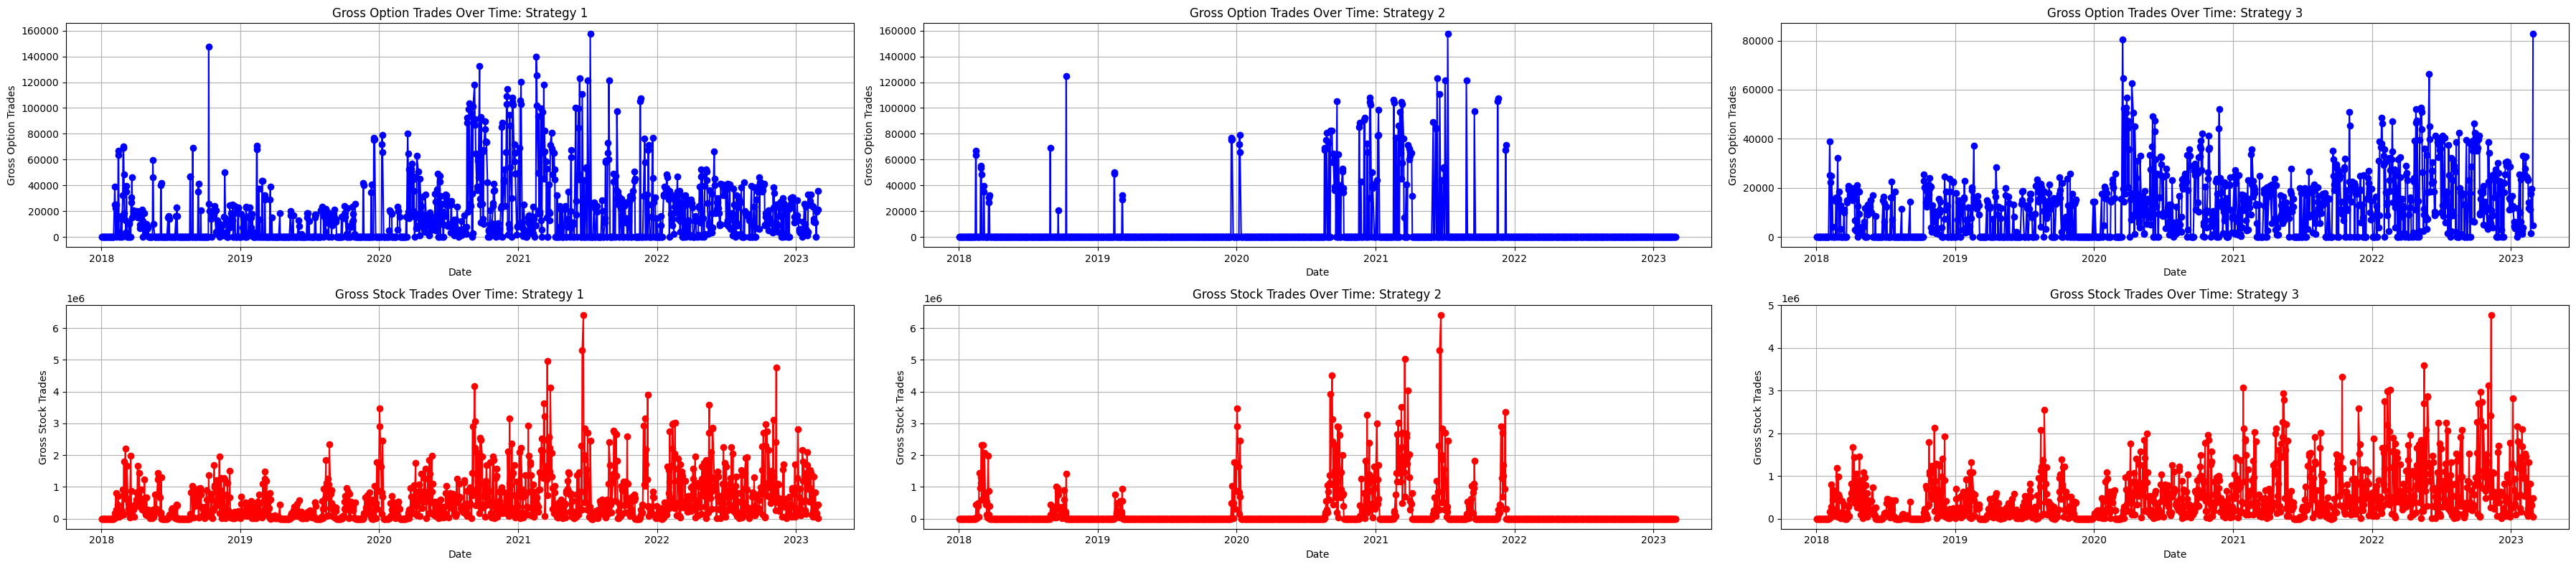

In [53]:
plot_trades_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

The plots above show patterns in gross option trades and gross stock trades over time for three different trading strategies.

For Strategy 1 and 3, the volume of gross option trades and gross stock trades is quite high with a significant number of spikes, suggesting periods of high trading activity coupled with quieter times. Strategy 2, on the other hand, has significantly fewer spikes in both gross option and stock volume traded over time. For all three strategies, the volume of option trades is significantly higher and more volatile than stock trades, as indicated by the greater frequency and amplitude of peaks in the blue lines. 

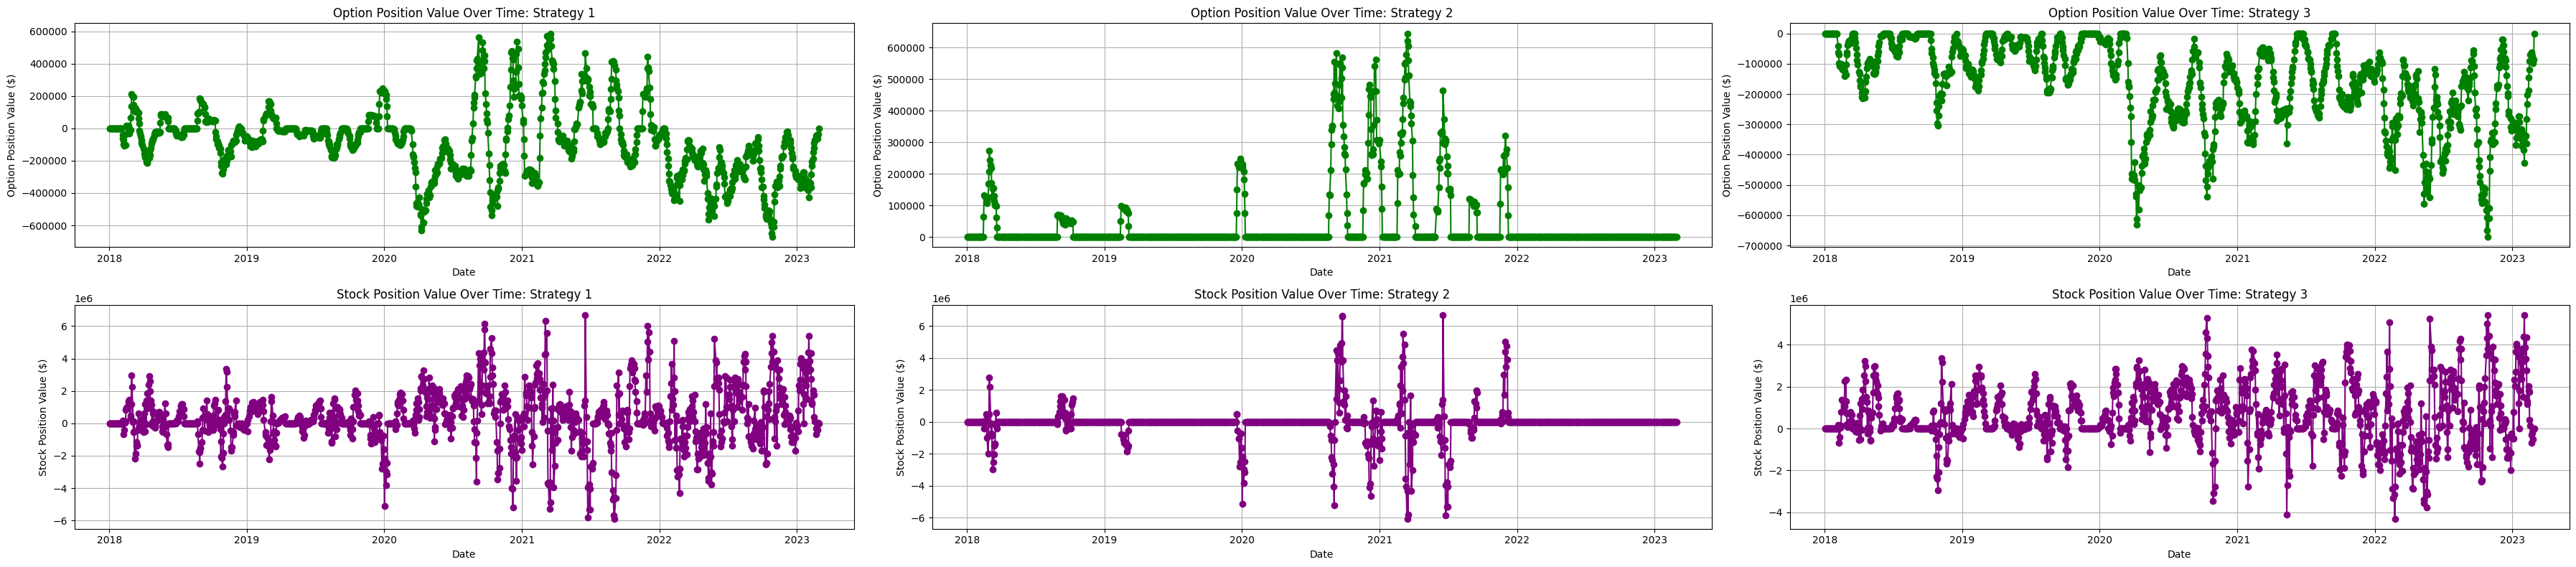

In [55]:
plot_position_values_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

The plots above illustrate the option and stock position values over time for the 3 trading strategies. 

In Strategy 1, there is significant fluctuations in option position value, with some periods showing substantial positive values, especially around 2020 and 2021, suggesting profitable option positions, followed by sharp declines indicating losses which can be attributed to the covid-19 pandemic. The stock position value for Strategy 1, while also volatile, generally oscillates around a narrower range compared to the options, indicating less extreme changes in value but with notable periods of loss. Strategy 3 shows a similar pattern to Strategy 1 in terms of fluctuations. For strategy 2, the option position value always stays positive and the stock position value has minimal deviation from zero. For strategy 3, however, the option position value over time fluctuates below zero while the stock position value oscillates both positive and negative. 

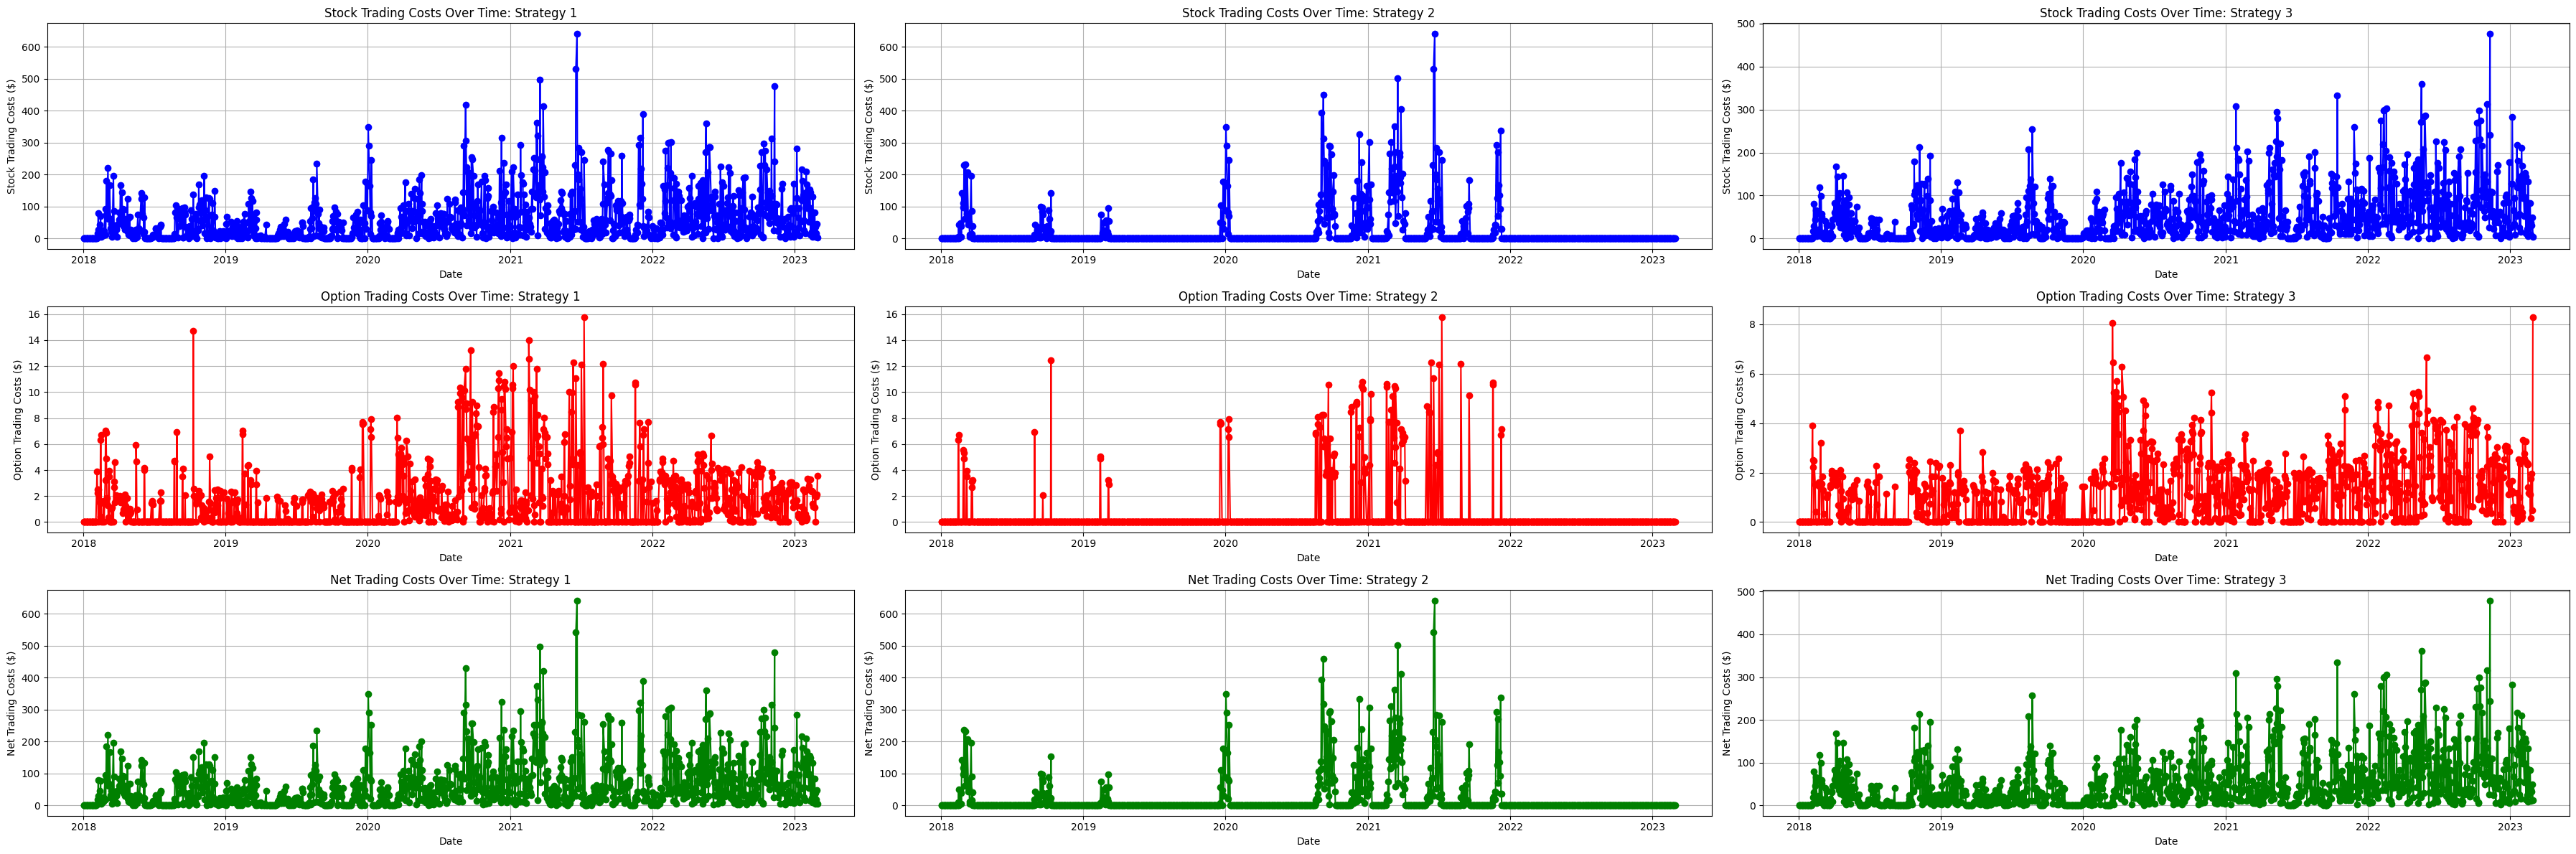

In [145]:
plot_trading_costs_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

The plots above show a visual representation of the trading costs associated with all 3 trading strategies. 

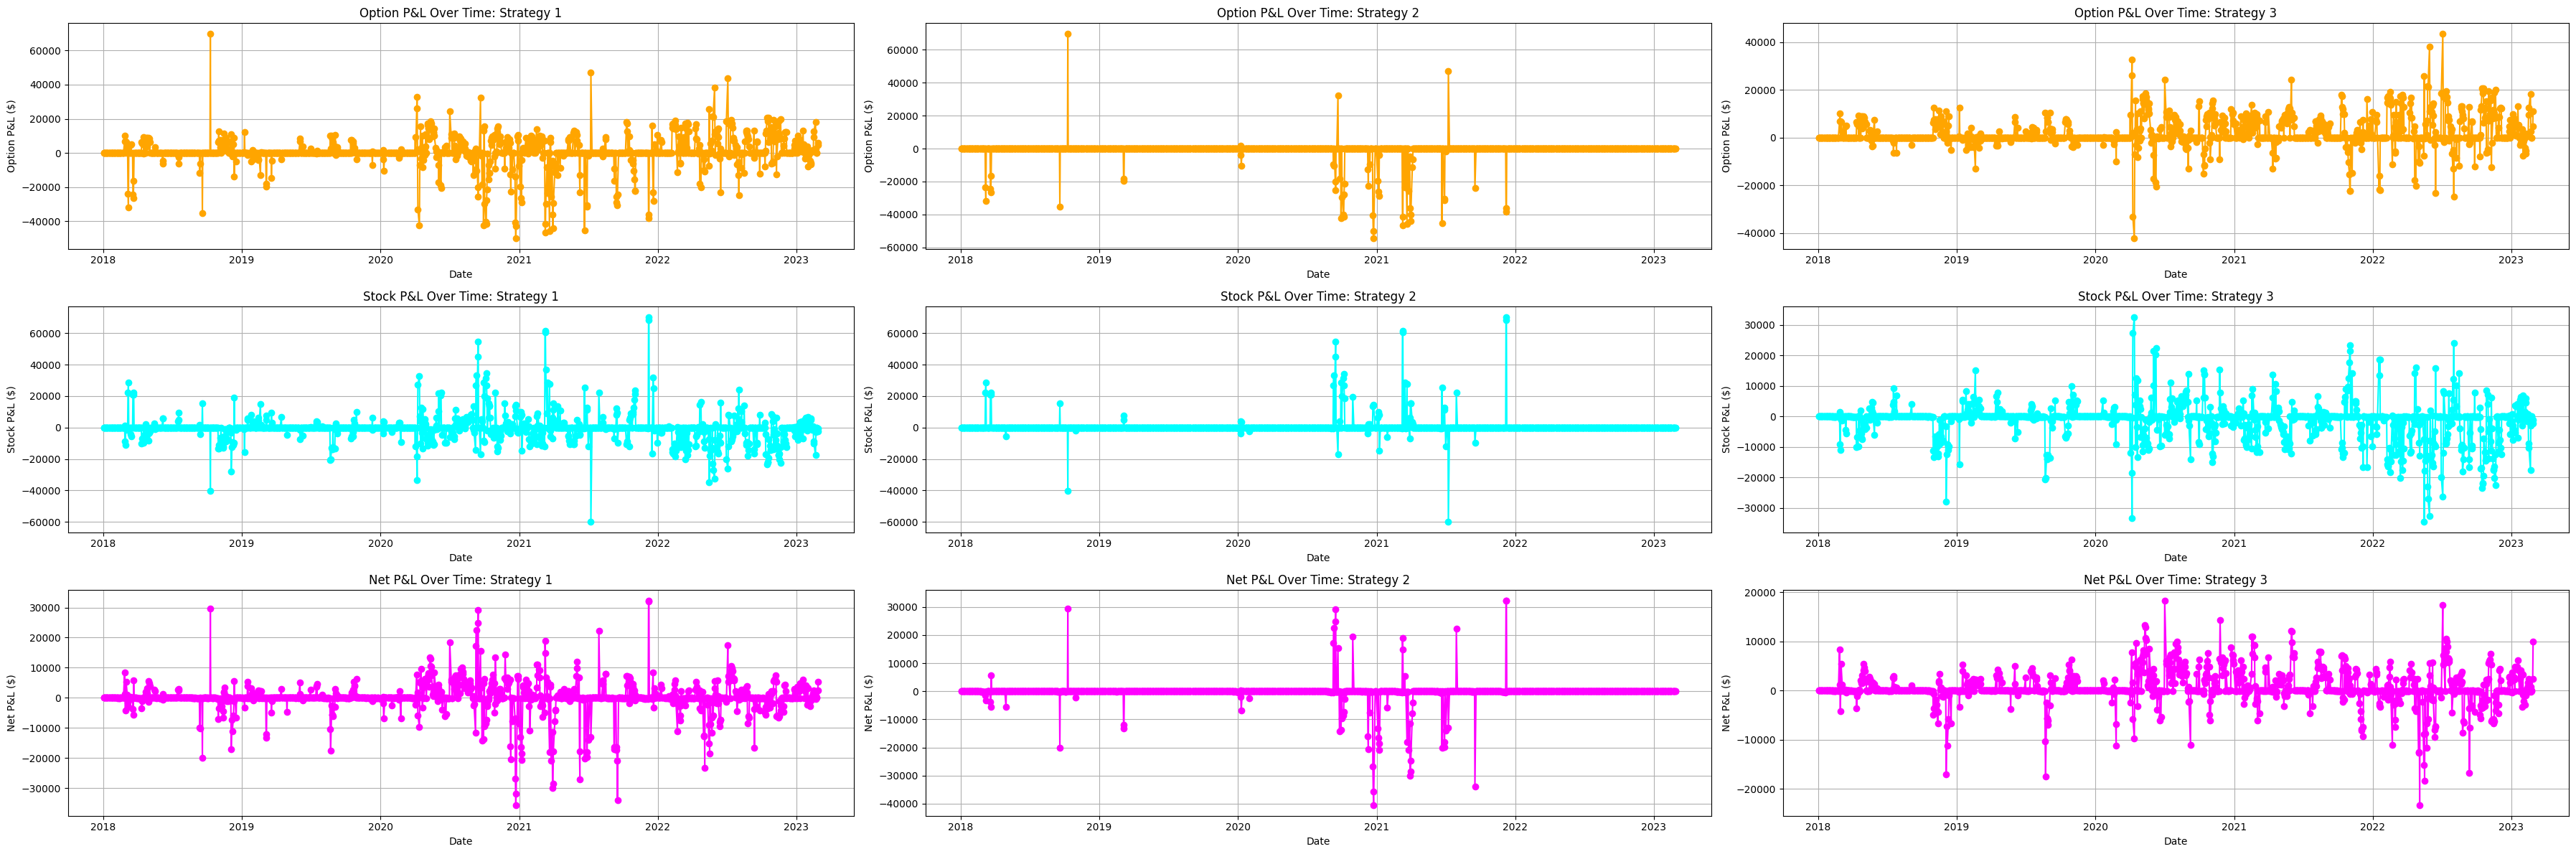

In [58]:
plot_pl_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

The plots above display the profit and loss (P&L) performance over time for the 3 different trading strategies. Across all strategies, option P&L tends to show greater variability and range compared to stock P&L, suggesting that options trading contributes more significantly to overall P&L fluctuations.

For Strategy 1, there's a consistent pattern of smaller losses and gains in stock trading, with larger outcomes in options trading, leading to an overall net P&L that exhibits a high-risk approach. Strategy 2 exhibits relatively less volatility particularly in the stock pnL, which appears to be slightly more stable. The net P&L for Strategy 2, while also volatile, does not seem to have very high peaks. 

Overall, all three strategies demonstrate periods of both profit and loss, with options trading contributing more prominently to the volatility and magnitude of overall results.

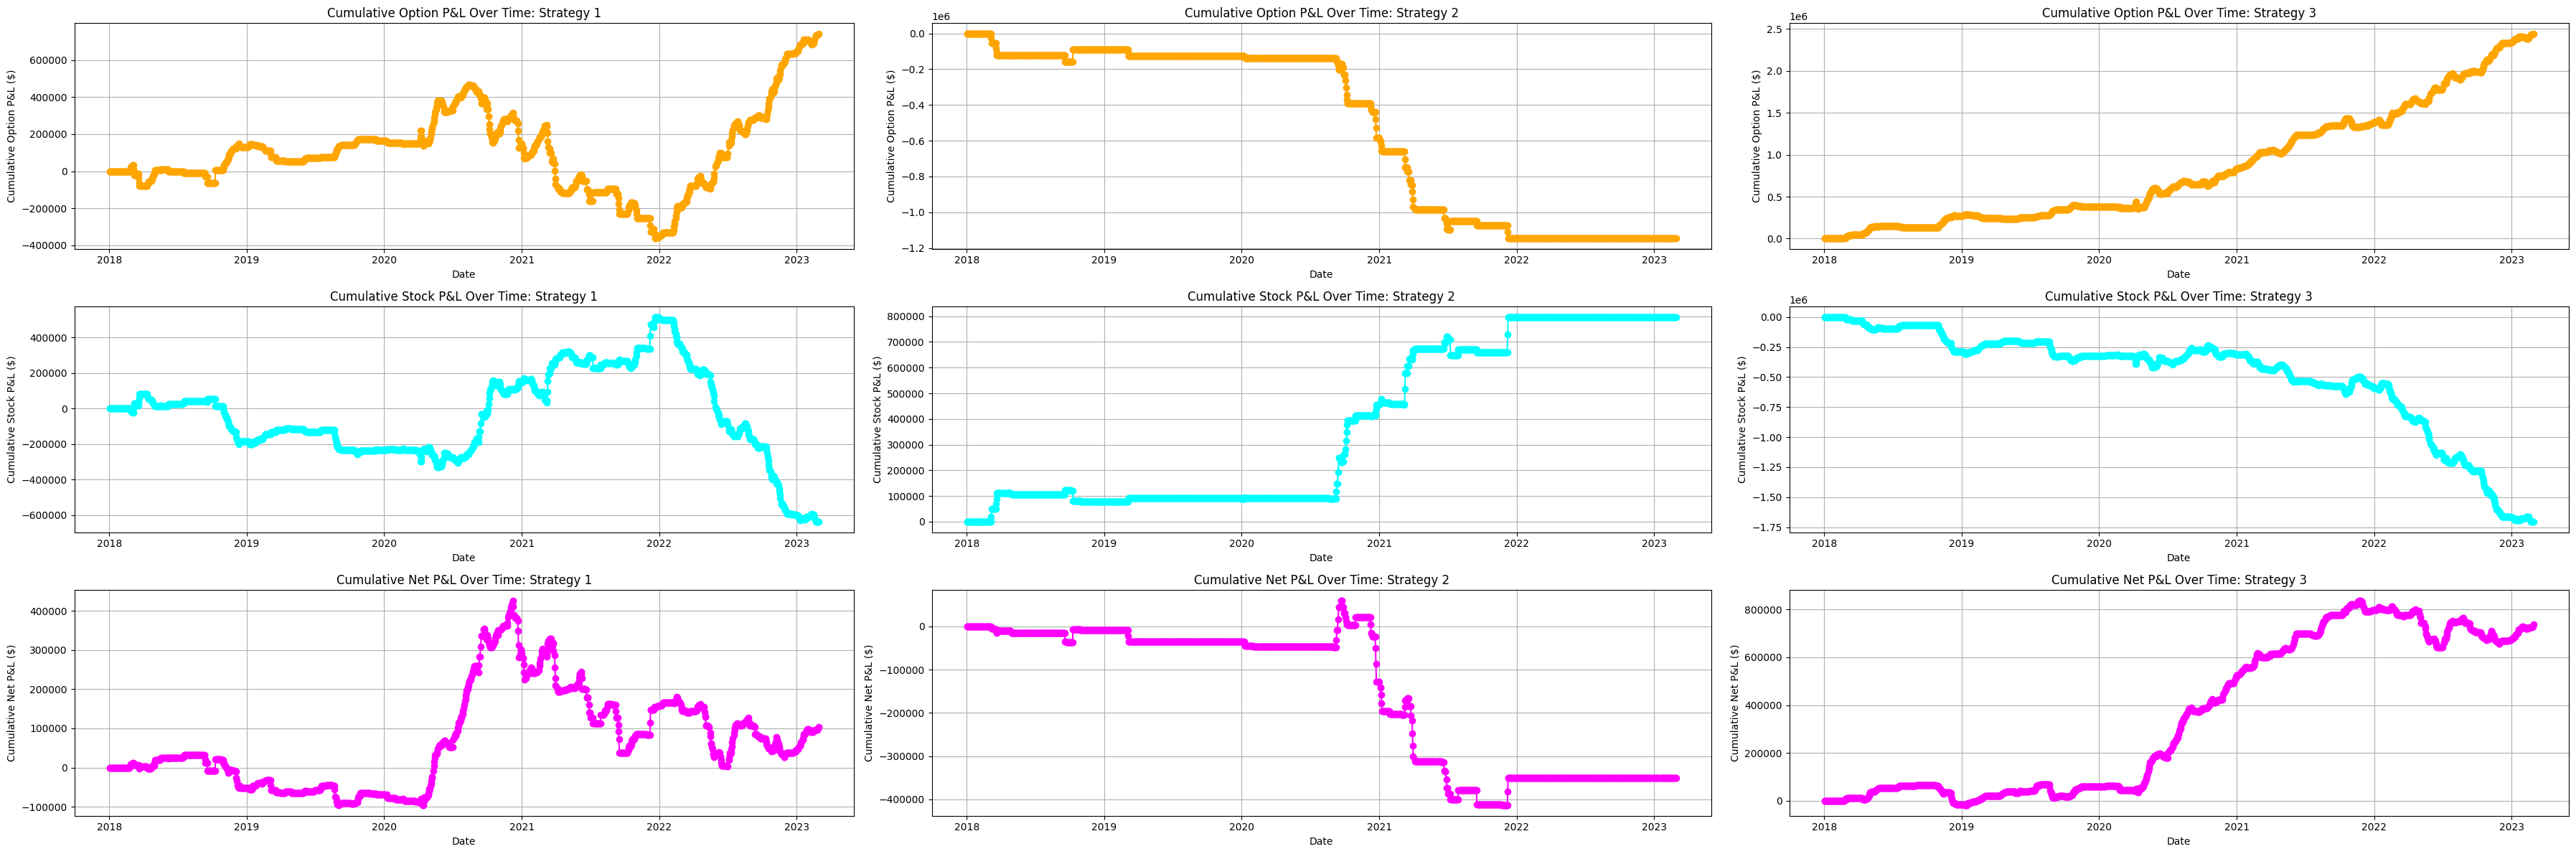

In [65]:
plot_cumulative_pl_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

The graphs above show the cumulative profit and loss (P&L) over time for the three different trading strategies.

For Strategy 1, the cumulative option P&L shows an overall increasing trend (with a drop between 2020 to 2022), indicating profitable option trading activities by the end of the time period. In contrast, the cumulative stock P&L exhibits a general decline, especially after 2022, suggesting that stock trades were less successful. The net P&L shows fluctuations with a general downward trend until around mid-2020, followed by some recovery till 2021 but still underperformings.

For Strategy 2,the cumulative option P&L is mostly flat but then sharply drops in mid-2021, reflecting significant losses. The stock P&L shows a gradual increase, indicating more consistent gains from stock trading, a contrast to the option results. However, the net P&L mirrors the option performance closely, plunging in 2021, which indicates the losses in options heavily impacted the overall strategy performance.

Strategy 3 reveals continuous growth in option P&L, signifying a consistently profitable option trading strategy over time. The stock P&L, however, declines steadily, suggesting persistent losses in stock trading. The net P&L for Strategy 3 shows improvement and growth, particularly from 2020 onwards, indicating that the gains from options have been sufficient to not only recover from any stock losses but also to generate overall profit.

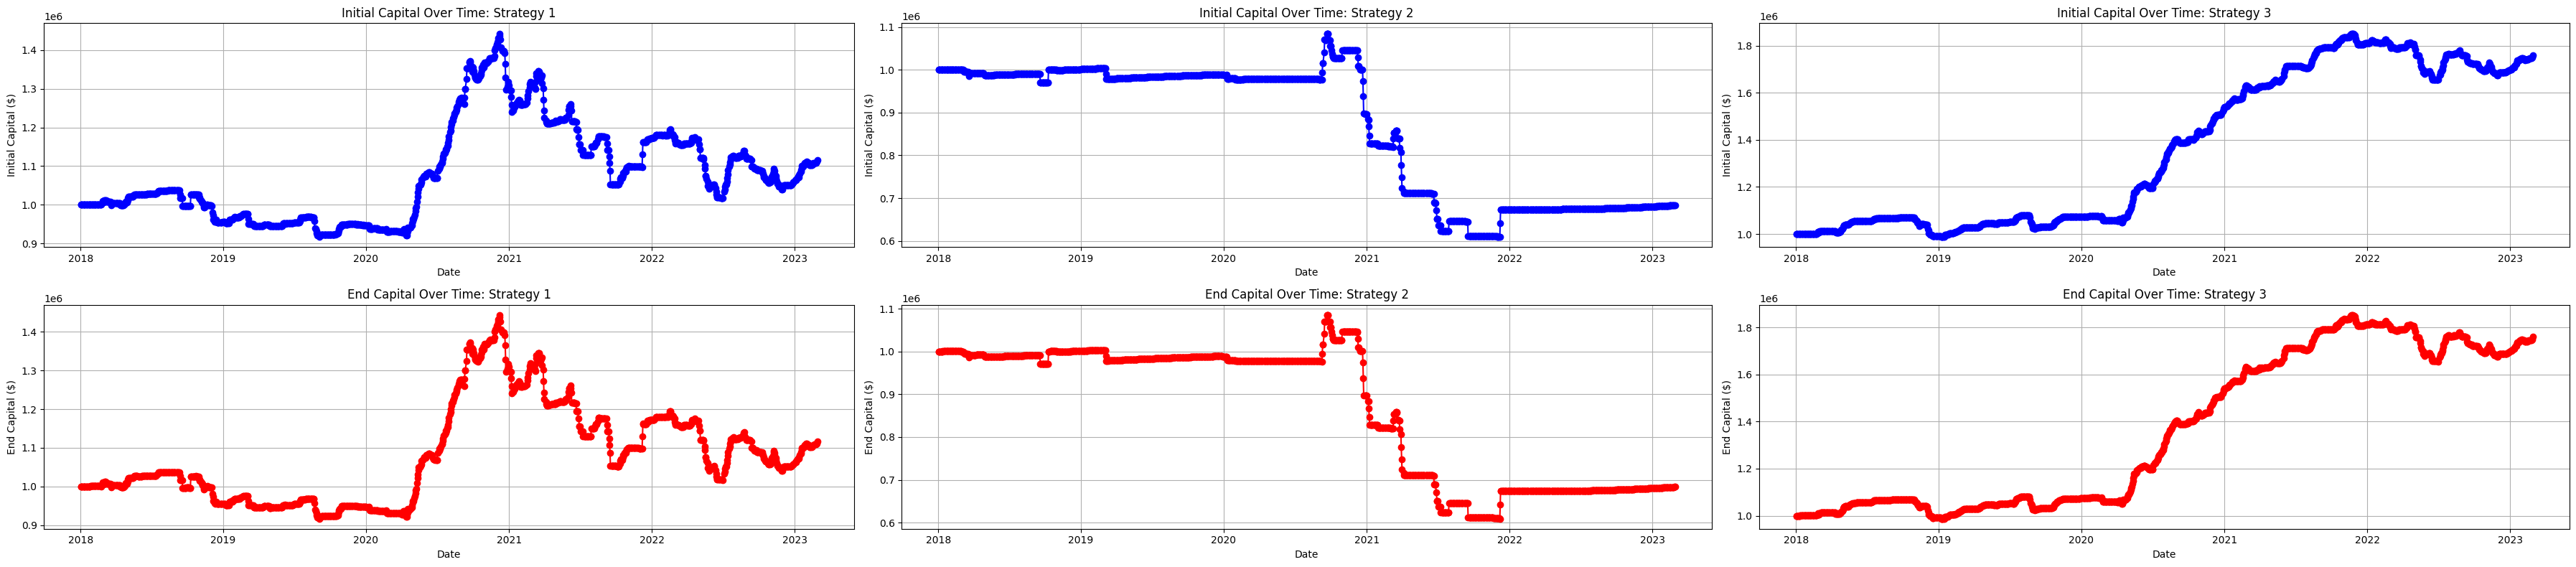

In [147]:
plot_kapital_over_time(PL_trade_1, PL_trade_2, PL_trade_3)

In the plots above, an increase in initial capital until 2021, which sees some decrease. Strategy 2 exhibits a stable initial capital until 2020, then both initial and end capitals plummet significantly with no signs of recovery. Strategy 3 demonstrates consistent growth in both initial and end capitals from 2020 onwards, indicating a successful and effective investment approach.

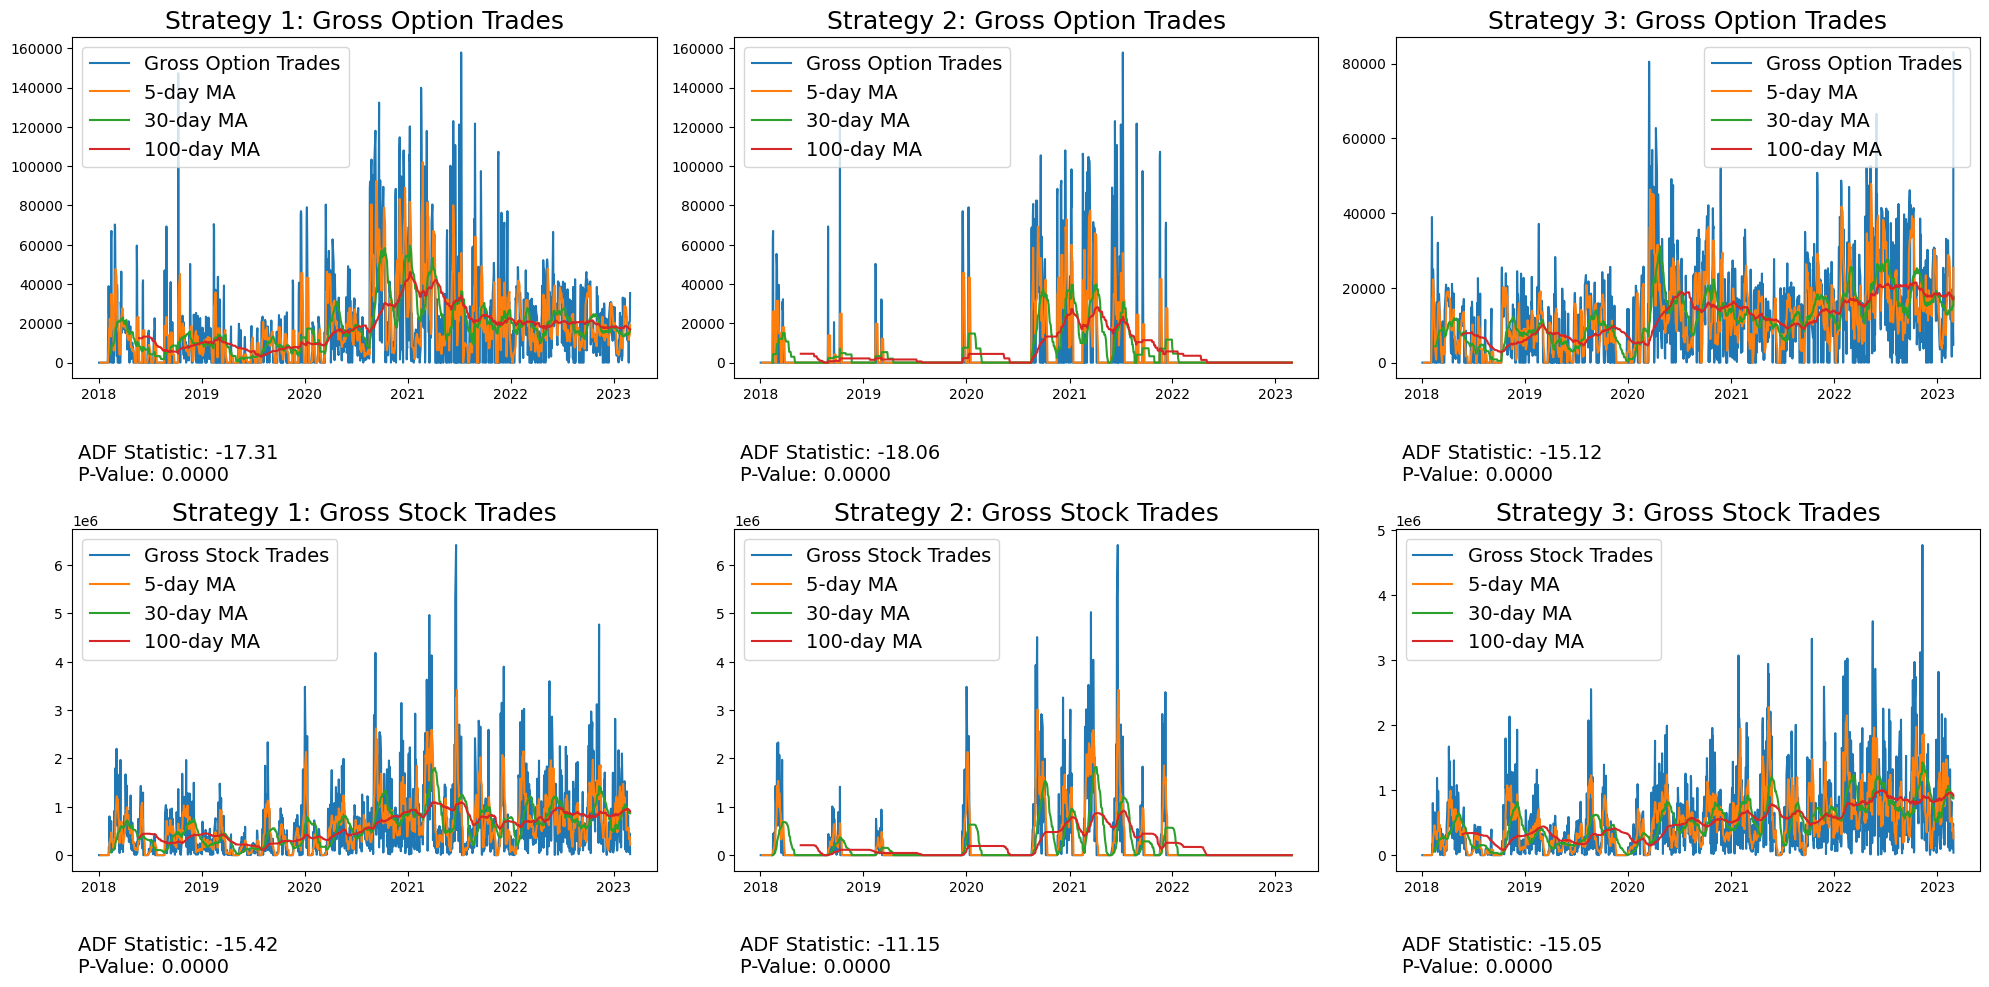

In [67]:
plot_trades_and_test_stationarity(PL_trade_1, PL_trade_2, PL_trade_3)

The charts show the gross option and stock trades over time for three different trading strategies, including their 5-day, 30-day, and 100-day moving averages (MAs). The moving averages smooth out short-term fluctuations and help identify longer-term trends in trading activity. The Augmented Dickey-Fuller (ADF) test results provided at the bottom of each graph further tell us about stationarity in the time series data.

For strategy 1, both gross option trades and gross stock trades have very negative ADF statistic values (-17.31 and -15.42, respectively) with p-values of 0.0000. This suggests strong evidence against the null hypothesis. 

For strategy 2, the ADF statistics for gross option trades and gross stock trades are -18.06 and -11.15 respectively. Similar to Strategy 1, these results strongly suggest that the series are stationary as the null hypothesis.

For strategy 3, again, the ADF statistics are -15.12 for gross option trades and -15.05 for gross stock trades, once again indicating that the null hypothesis can be rejected. 

The consistency in the stationarity across all strategies for both option and stock trades indicates that these trading behaviors have stable dynamics, which could potentially make them more predictable and relatively more manageable from a risk perspective.

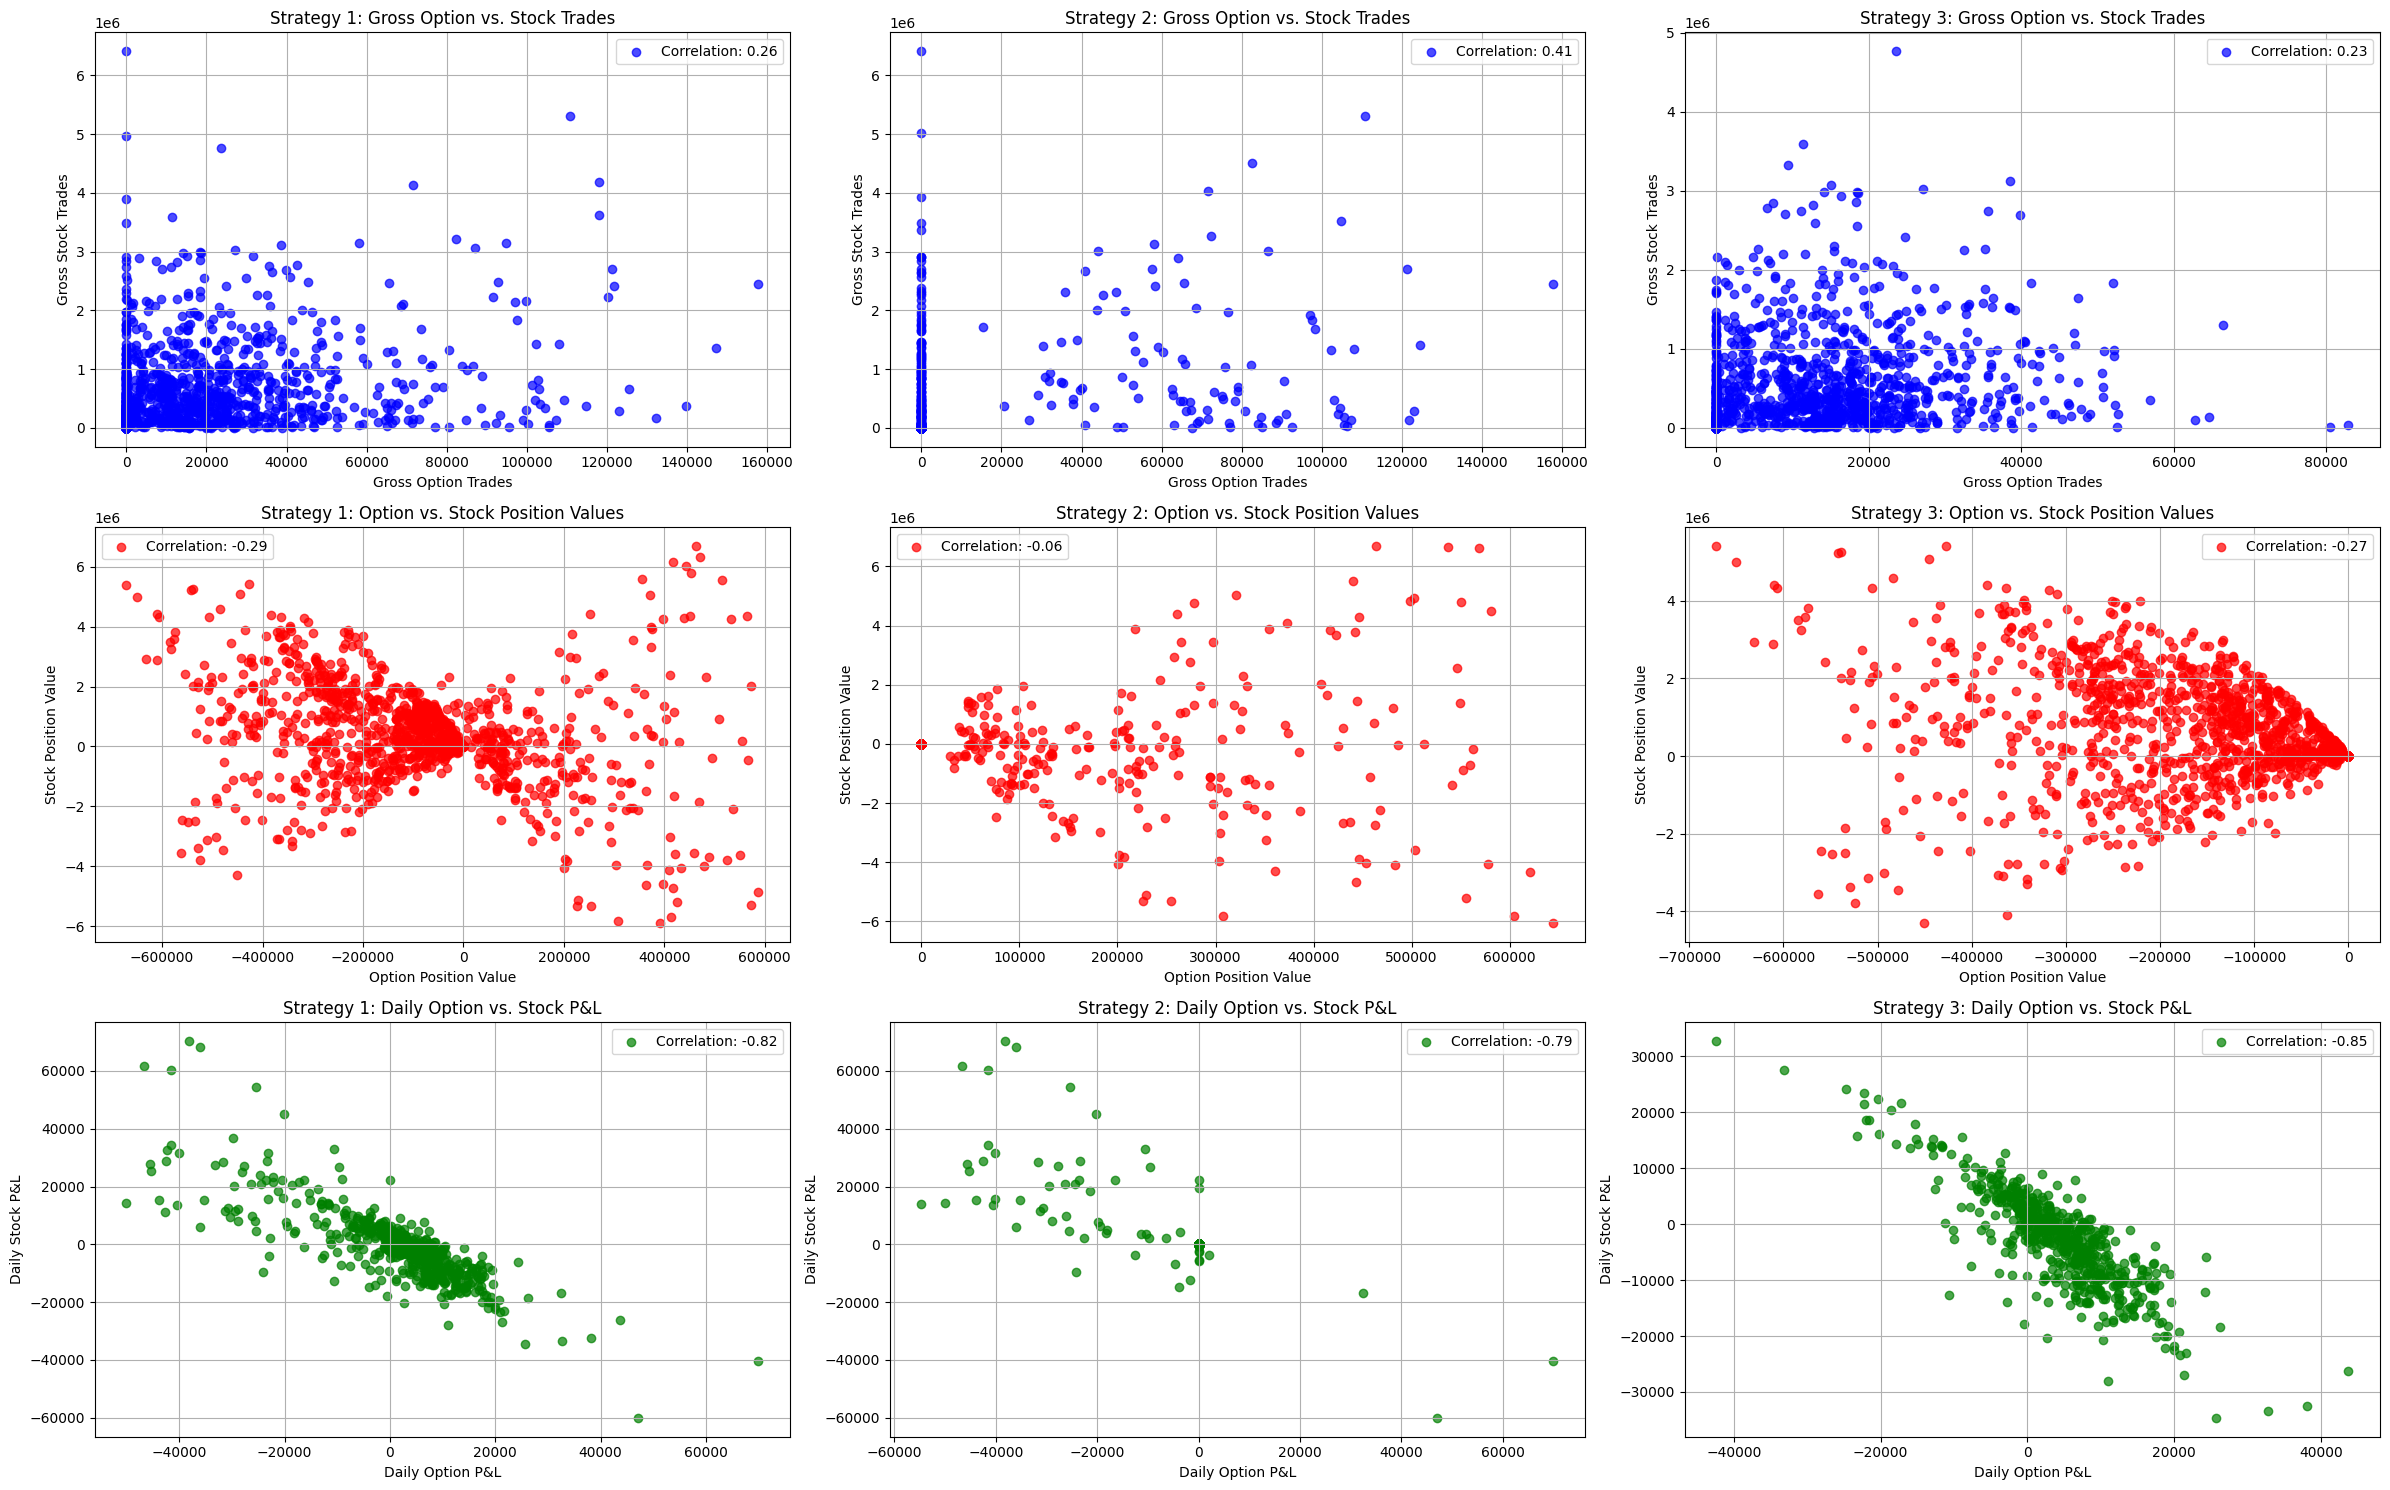

In [74]:
plot_correlations(PL_trade_1, PL_trade_2, PL_trade_3)

The charts display scatter plots with correlation coefficients, comparing Gross Option Trades vs. Stock Trades, Option vs. Stock Position Values, and Daily Option P&L vs. Stock P&L.

For Gross Option Trades vs. Stock Trades, Strategy 1 has a low positive correlation (0.26), indicating a slight relationship between the volume of option trades and stock trades. The data points are spread out, showing no strong linear relationship. Strategy 2 shows a moderate positive correlation (0.41), suggesting a greater relationship between the volume of options and stock trades compared to Strategy 1.
Strategy 3 has a low positive correlation (0.23), similar to Strategy 1, indicating a slight relationship between the volumes.

For Option vs. Stock Position Values, all three strategies show negative correlations: -0.29 for Strategy 1, -0.06 for Strategy 2, and -0.27 for Strategy 3. These correlations suggest that, generally, as the value of option positions increases, the value of stock positions decreases, and the other way around.

For Daily Option P&L vs. Stock P&L, Strategy 1 exhibits a strong negative correlation (-0.82), indicating that on days when options P&L is high, stock P&L tends to be low, and the other way around. Strategy 2 and Strategy 3 both exhibit strong negative correlations as well (-0.79 and -0.85, respectively)

The strong negative correlations between daily option P&L and stock P&L across all strategies indicate a hedging relationship where options offset stock losses and stocks offset options losses.

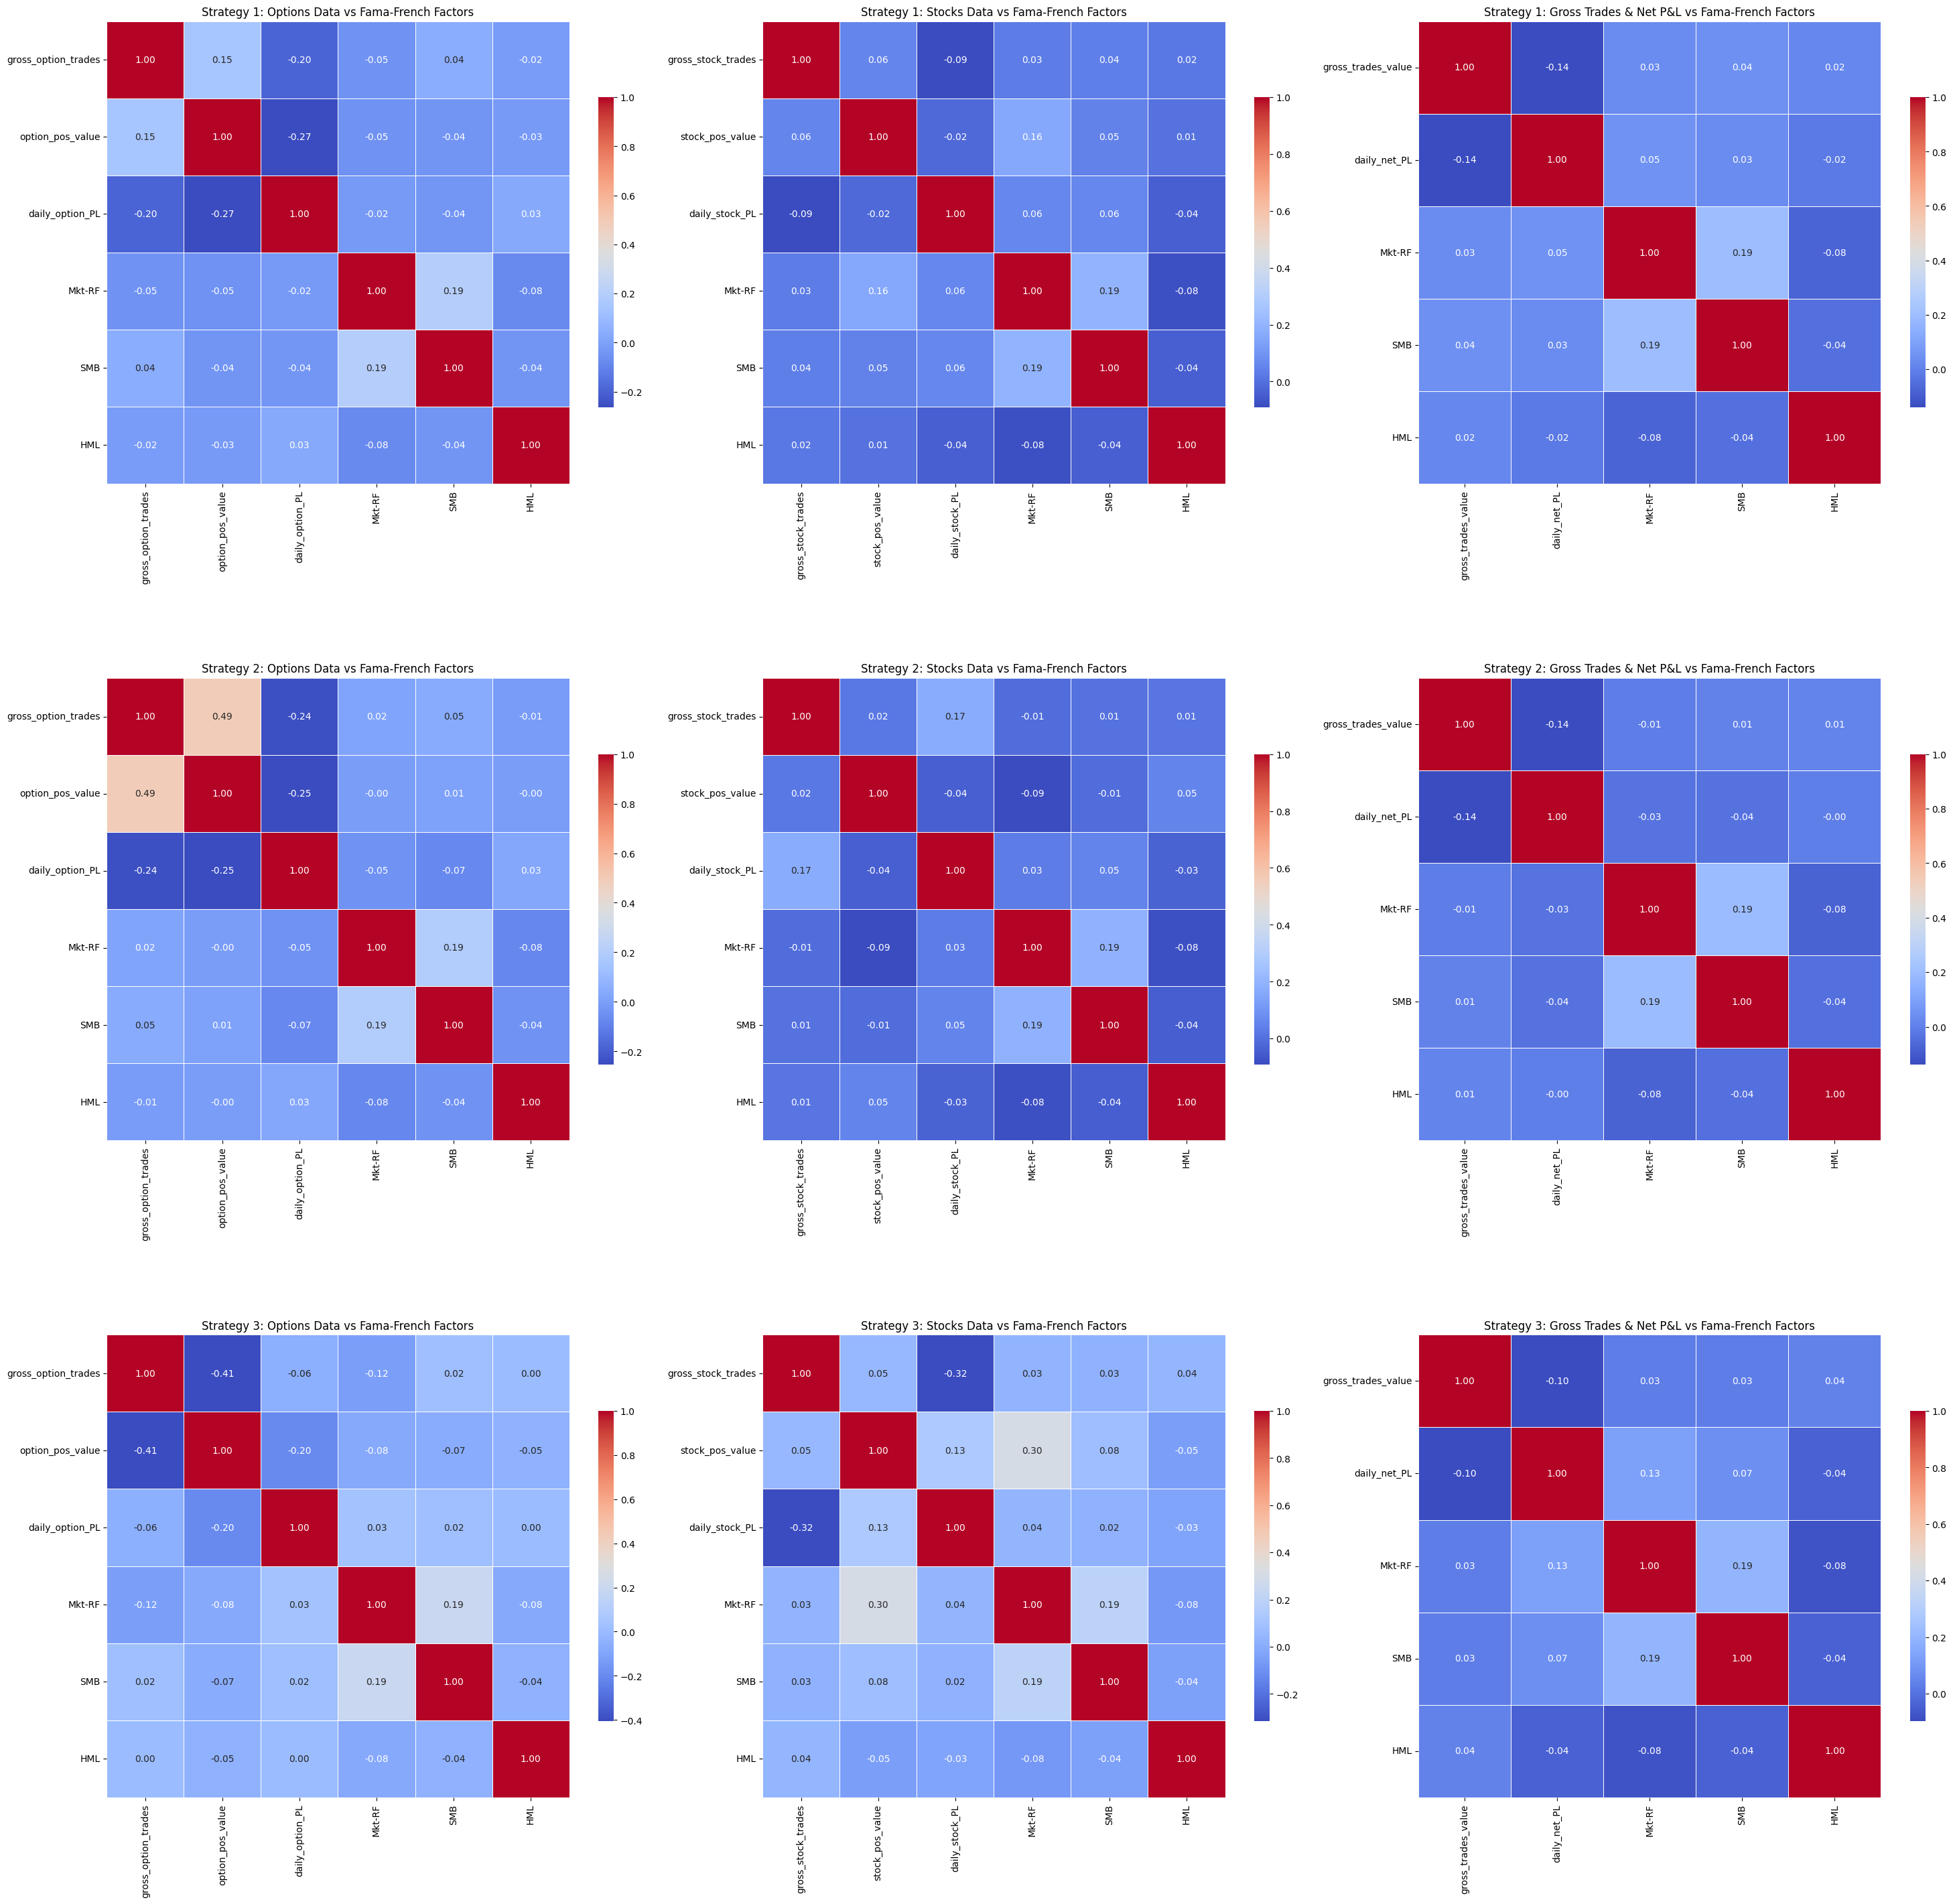

In [76]:
plot_correlation_matrices(PL_trade_1, PL_trade_2, PL_trade_3, fff_data=fff_data)

The plots above show correlation matrices between vgross option trades, gross stock trades, daily option P&L, and daily stock P&L and Fama-French factors (market return - Mkt, small minus big - SMB, high minus low - HML, and risk-free rate - RF) for three different strategies.

For strategy 1, gross option trades, stock trades, and daily P&Ls have relatively low to correlations with market returns (Mkt), indicating that these activities are not strongly driven by overall market movements. Similar to Strategy 1, there is similar low correlation between the trading metrics and farma french factors for strategy 2. Stock position value has a correlation of -0.09 with the market factor. For strategy 3, stock position value has a moderate positive correlation of 0.30 with the market factor while the daily net PL has a slightly positive correlation of 0.13 with the market factor and 0.07 with SMB. 

In summary, these correlation matrices provide insight into how each strategy's trades and daily performance relate very weakly to broader market and factor behaviors. 

In [80]:
combined_1 = PL_trade_1.merge(fff_data, left_index=True, right_index=True, how='left')
combined_2 = PL_trade_2.merge(fff_data, left_index=True, right_index=True, how='left')
combined_3 = PL_trade_3.merge(fff_data, left_index=True, right_index=True, how='left')

In [82]:
run_regression_option_PL(combined_1, combined_2, combined_3)

Strategy 1: R-squared of the regression of option_PL on the Fama-French factors: 0.004904

Strategy 1 regression summary:
                            OLS Regression Results                            
Dep. Variable:              option_PL   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.126
Date:                Fri, 08 Mar 2024   Prob (F-statistic):             0.0952
Time:                        12:44:39   Log-Likelihood:                -17812.
No. Observations:                1298   AIC:                         3.563e+04
Df Residuals:                    1294   BIC:                         3.565e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

The three regression results that use the farma french factors to predict option_PL show very small R^2 values, with the best performing regression being strategy 1 with an R^2 value of 0.005. No factors individually had a significant p-value. 

In [84]:
run_regression_stock_PL(combined_1, combined_2, combined_3)

Strategy 1: R-squared of the regression of stock_PL on the Fama-French factors: 0.004653

Strategy 1 regression summary:
                            OLS Regression Results                            
Dep. Variable:               stock_PL   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.016
Date:                Fri, 08 Mar 2024   Prob (F-statistic):              0.110
Time:                        12:45:56   Log-Likelihood:                -17970.
No. Observations:                1298   AIC:                         3.595e+04
Df Residuals:                    1294   BIC:                         3.597e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

Very similar to the regression results from option_PL, the three regression results that use the farma french factors to predict stock_PL show very small R^2 values, with the best performing regression again being strategy 1 with an R^2 value of 0.005. No factors individually had a significant p-value. 

In [86]:
run_regression_net_PL(combined_1, combined_2, combined_3)

Strategy 1: R-squared of the regression of net_PL on the Fama-French factors: 0.007555

Strategy 1 regression summary:
                            OLS Regression Results                            
Dep. Variable:                 net_PL   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.283
Date:                Fri, 08 Mar 2024   Prob (F-statistic):             0.0202
Time:                        12:47:09   Log-Likelihood:                -17040.
No. Observations:                1298   AIC:                         3.409e+04
Df Residuals:                    1294   BIC:                         3.411e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

Once again, very similar to the regression results from option_PL and stock_PL, the three regression results that use the farma french factors to predict net_PL show very small R^2 values, with the best performing regression again being strategy 1 with an R^2 value of 0.008. Once again, no factors individually had a significant p-value in any of the 3 regressions (although the HML factor was close for strategy 1 and strategy 3). 

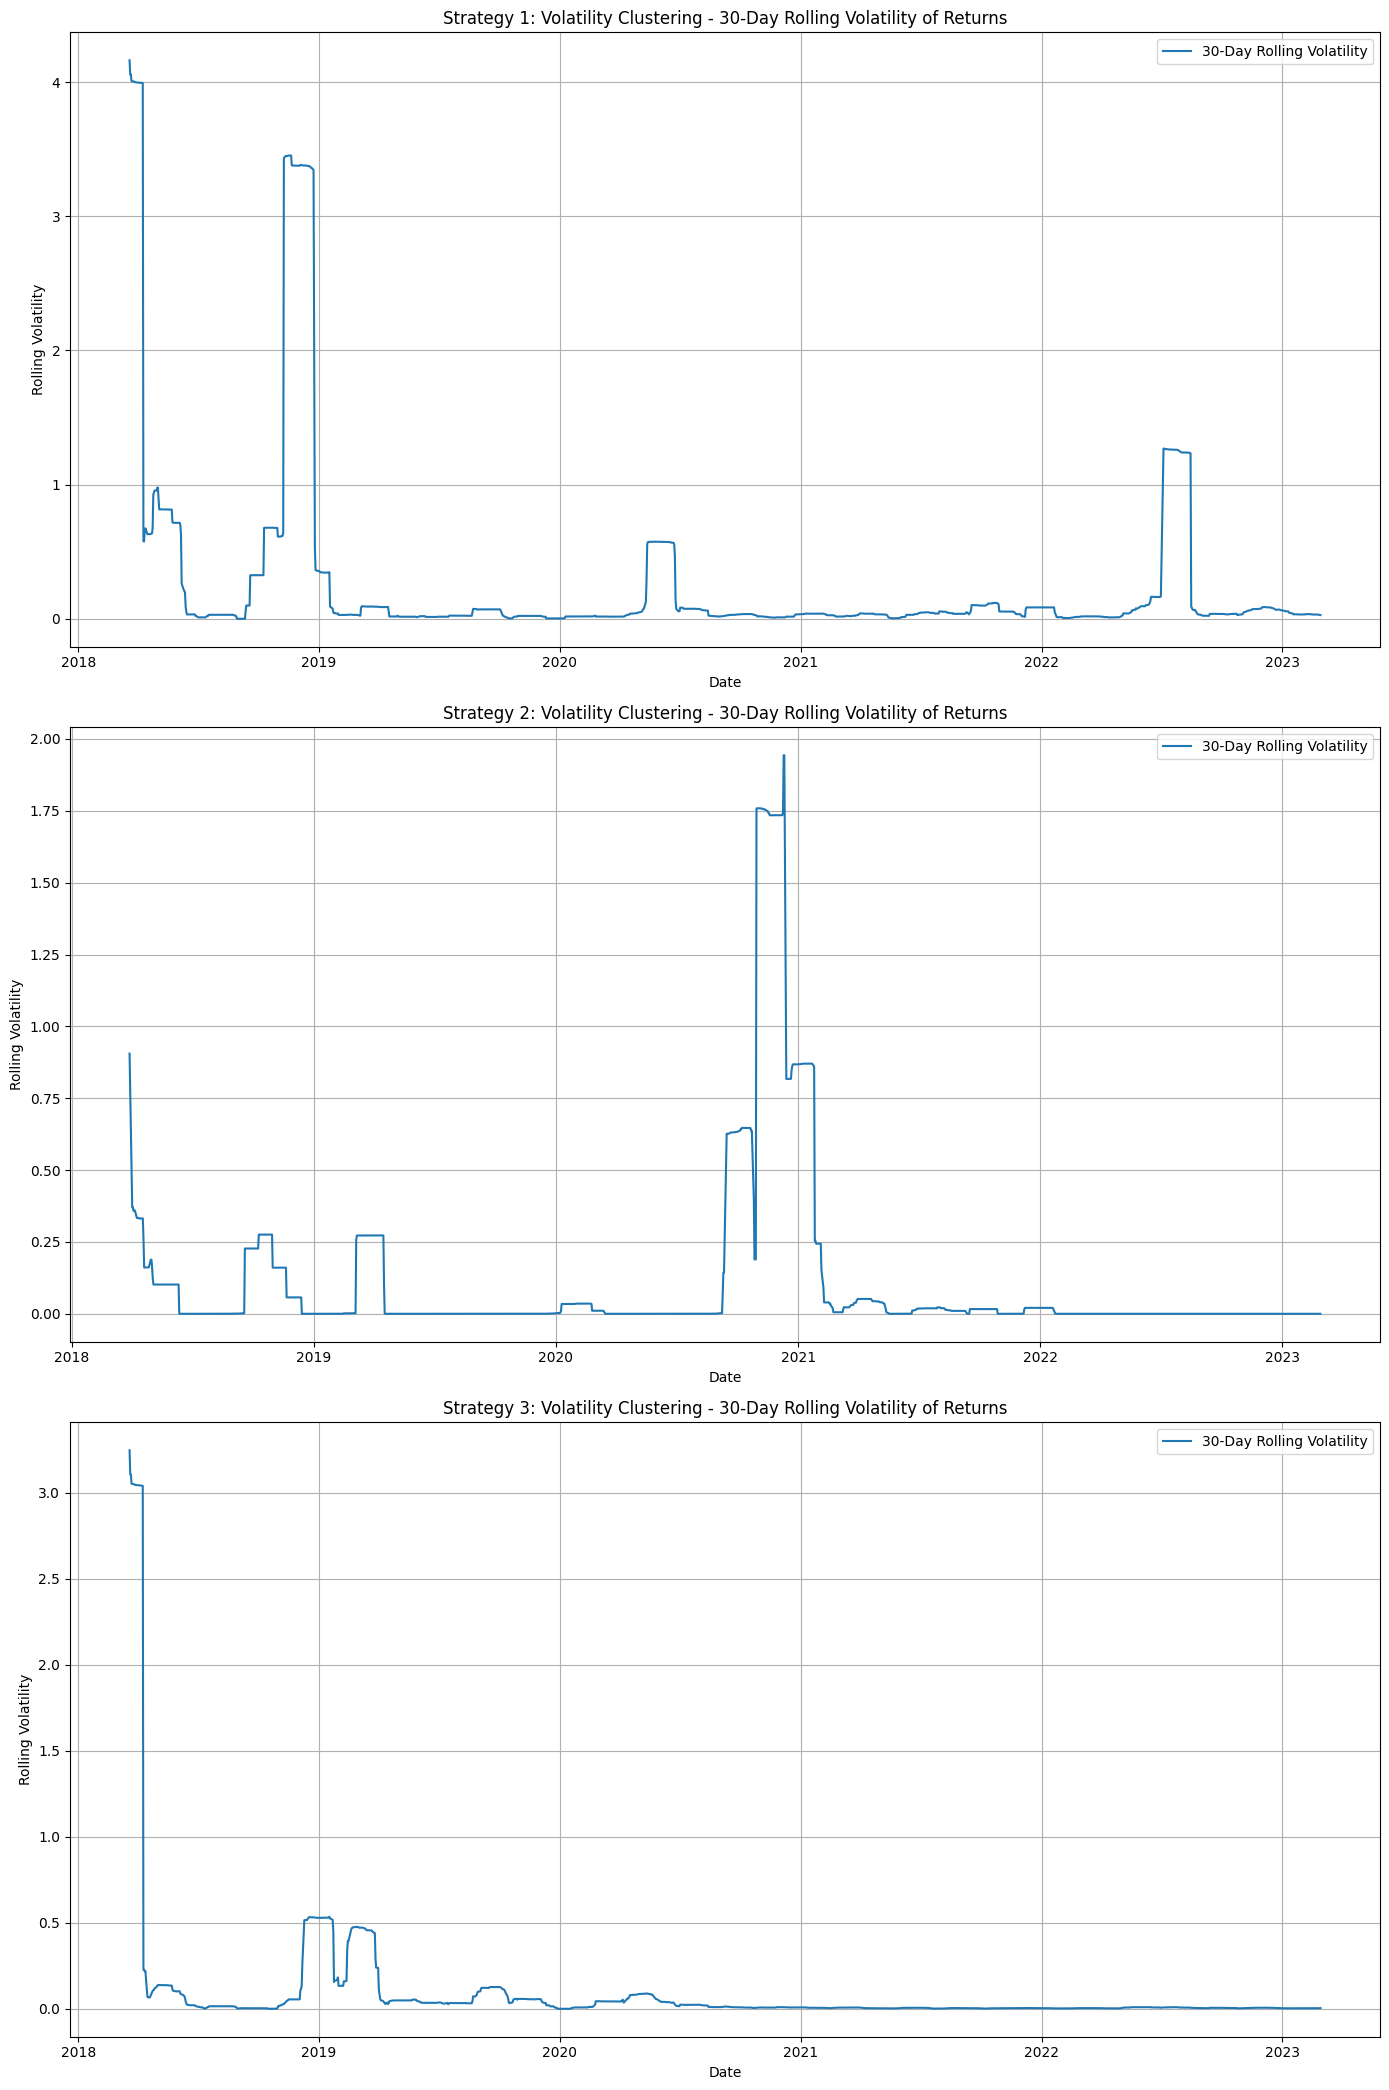

In [88]:
plot_rolling_volatility(combined_1, combined_2, combined_3, window_size=30)

The graphs illustrate the 30-day rolling volatility of returns for the 3 trading strategies.

The volatility profile for Strategy 1 shows significant peaks, particularly around early 2019, 2020, and 2022. The volatility profile for strategy 2, on the other hand, is slightly different with major peaks in 2018 and a huge spike in 2020, staying constant otherwise. Strategy 3 also has a very different volatility profile, having elevated spiked from 2018 to 2019, followed by flat rolling vol for the rest of the trading period. 

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/3721504081.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df['monthly_pnl'] = combined_df['net_PL'].resample('M').last().diff()


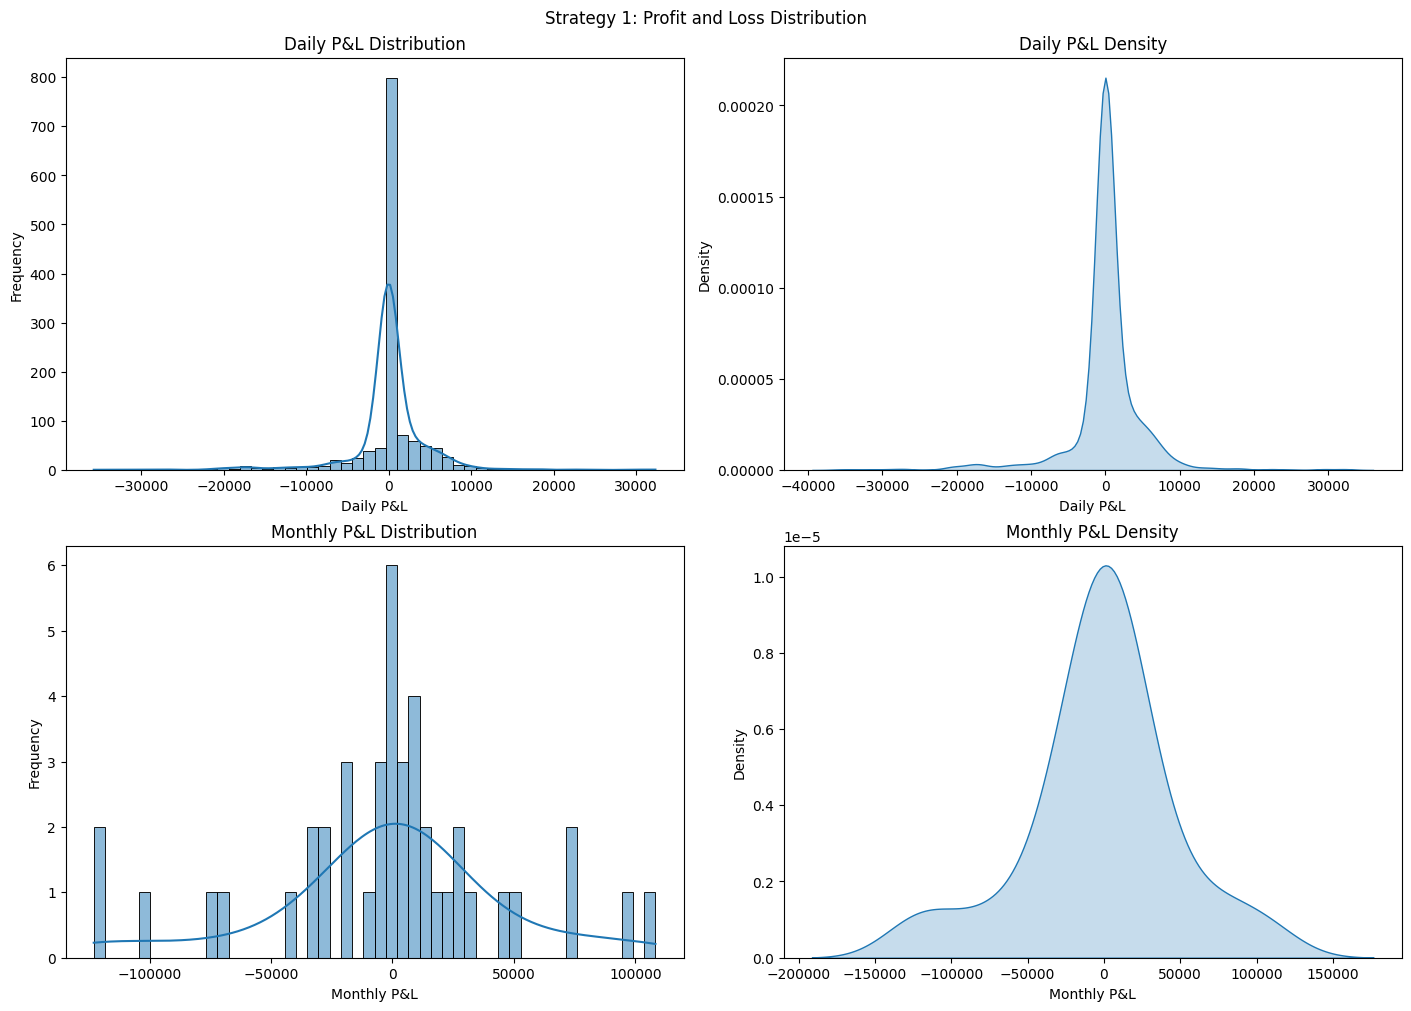

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/3721504081.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df['monthly_pnl'] = combined_df['net_PL'].resample('M').last().diff()


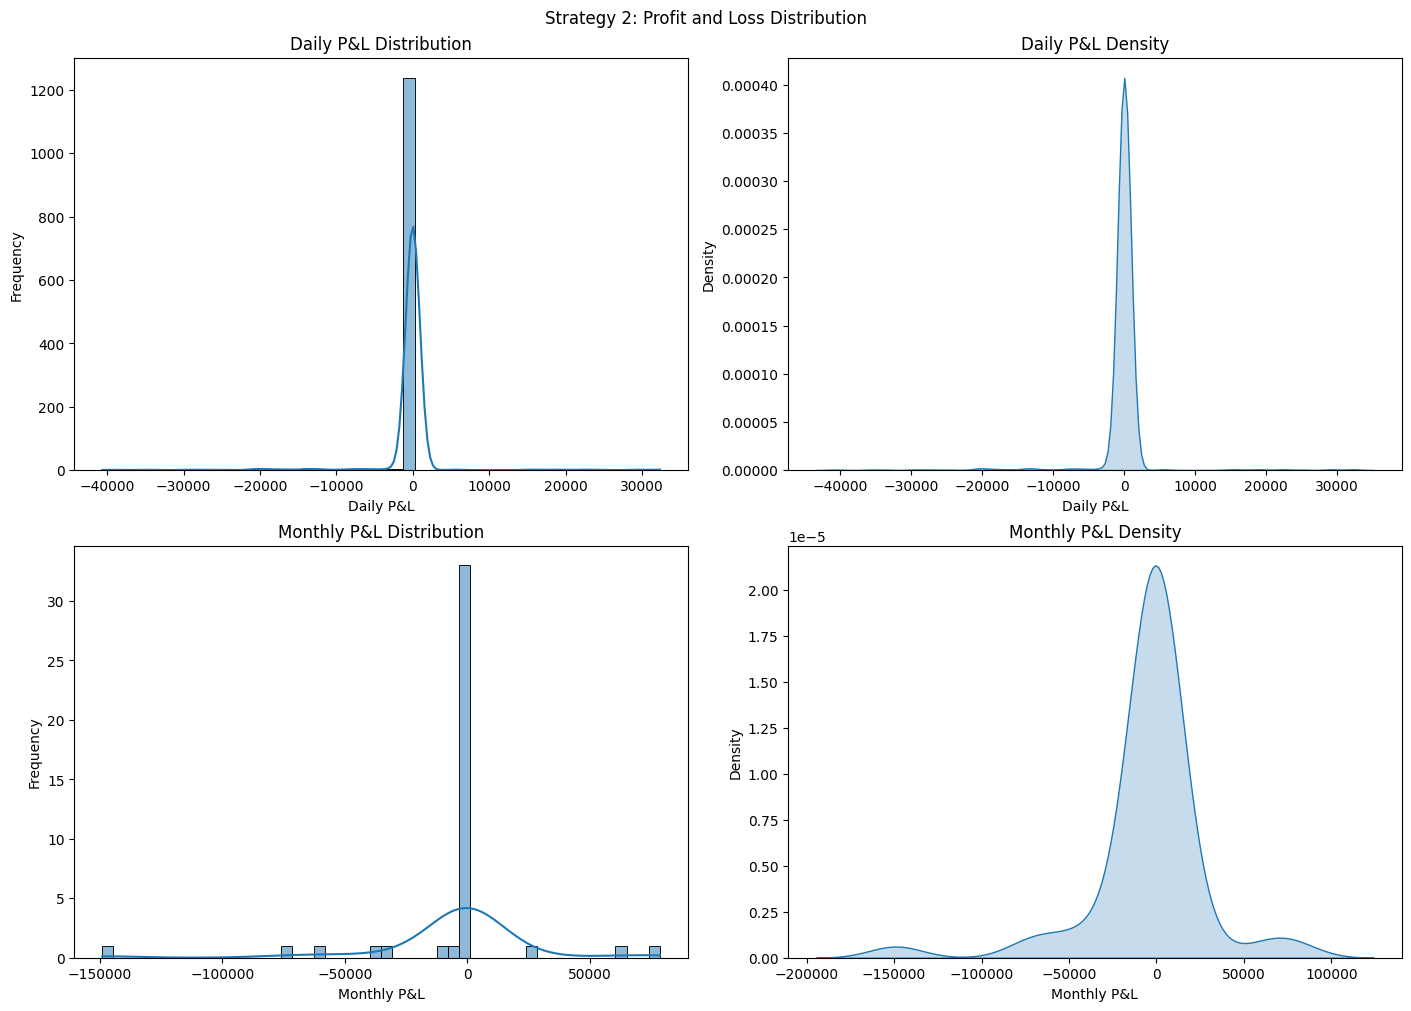

/var/folders/37/_d3r4q095fs6bf6w7rqvdkf40000gn/T/ipykernel_35323/3721504081.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df['monthly_pnl'] = combined_df['net_PL'].resample('M').last().diff()


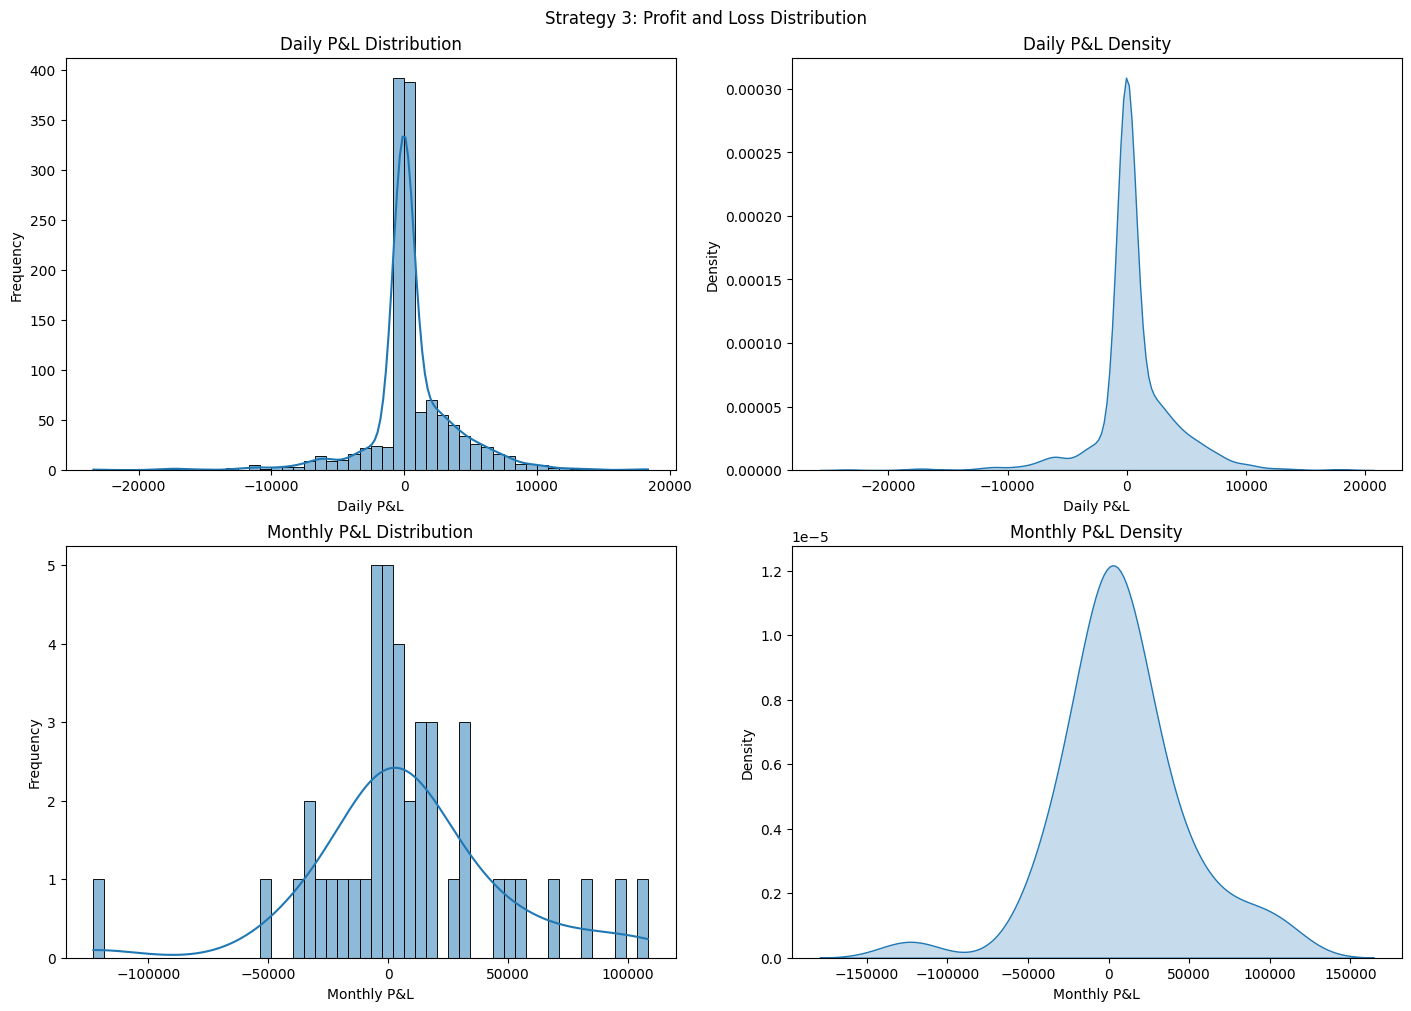

In [102]:
plot_pnl_distribution(combined_1, combined_2, combined_3)

The profit and loss (P&L) distribution for Strategy 1 indicates that on a daily basis, returns are typically close to zero but with a slight skew towards losses, as shown by the sharp peak and longer left tail in the daily distribution plots. In contrast, the monthly P&L exhibits greater variability and a slight positive skew, indicating that while day-to-day results are often negligible or slightly negative, the aggregate monthly outcomes display a wider range of results with potential for profitability. This suggests that Strategy 1 experiences regular minor losses or gains daily but has the capacity for broader, more significant outcomes on a monthly basis, possibly due to cumulative effects of the trading strategy over a longer period.

For Strategy 2, the daily P&L distribution and density plot show a very narrow, sharp peak around zero, indicating extremely consistent results on a day-to-day basis with minimal deviation from zero, suggesting very low daily volatility. In contrast, the monthly P&L distribution exhibits a wider range of outcomes with a significant peak at zero but with a notable spread, as seen in the histogram and density plot, suggesting that while daily returns are consistently close to neutral, the cumulative effect over the month can result in a wider range of profit and loss outcomes.

For Strategy 3, the daily P&L distribution again has a sharp peak around zero, indicating that most days result in minimal profit or loss, but with a visible spread indicating occurrences of both significant gains and losses. The density plot supports this with a narrow peak. The monthly P&L distribution and density show a more dispersed range than the daily figures, with a central peak slightly skewed towards the right, leaning towards profitability.

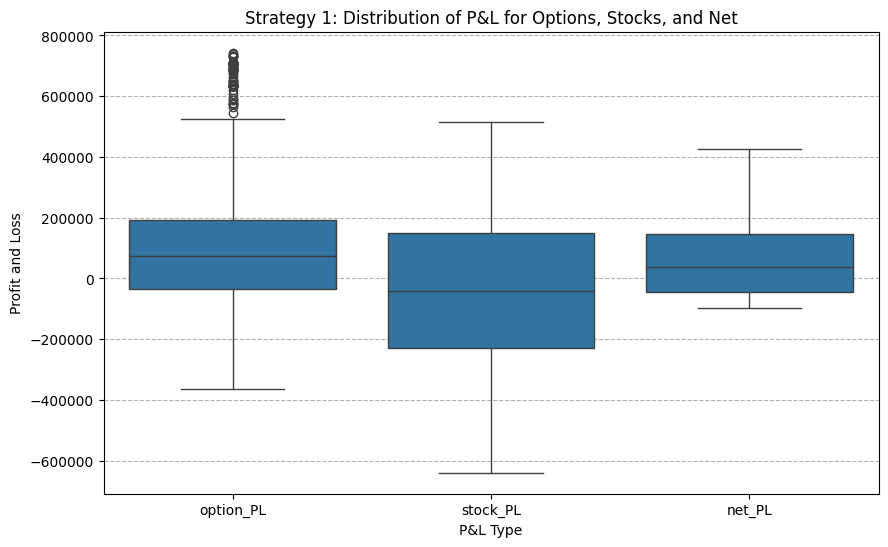

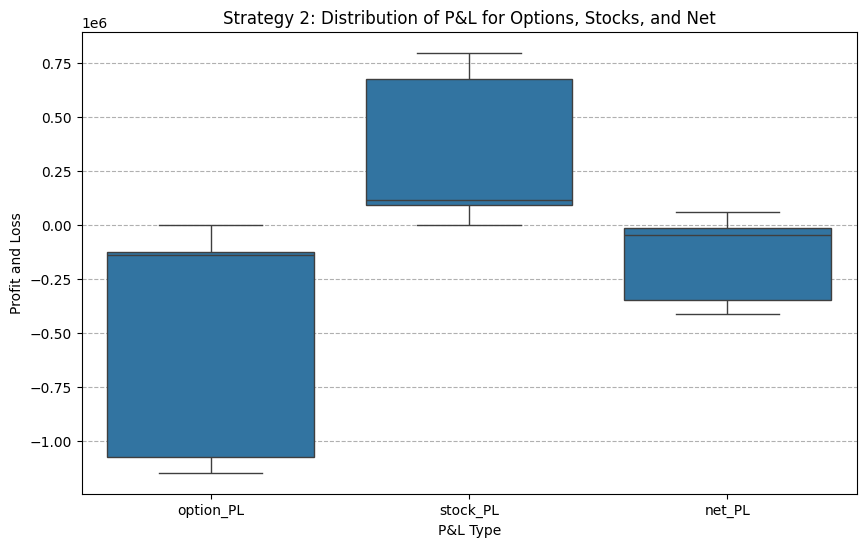

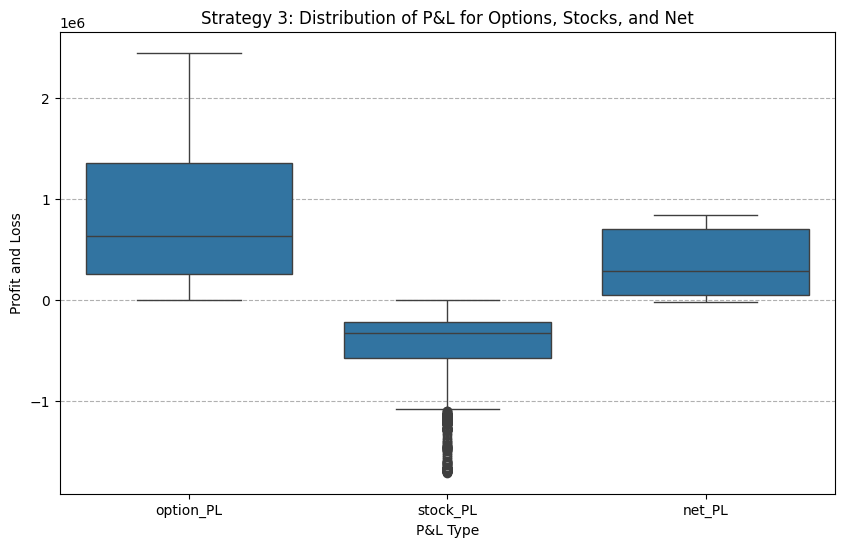

In [97]:
plot_pl_boxplots(combined_1, combined_2, combined_3)

The box plots above show the min, max, median, 1st, and 3rd quartiles of the option, stock, and net PL of all 3 trading strategies. These results were already analyzed with the performance summary above. Nevertheless, they show a visual representaion of these statistical parameters. 

In [99]:
calculate_profit_factor_analysis(combined_1, combined_2, combined_3)

Strategy 1: Option Profit Factor: 1.3151748045704375
Strategy 1: Stock Profit Factor: 0.772373554499564

Strategy 2: Option Profit Factor: 0.11664217051956986
Strategy 2: Stock Profit Factor: 4.939689657008045

Strategy 3: Option Profit Factor: 3.6354558279313216
Strategy 3: Stock Profit Factor: 0.41341462981838445



The results show the profit factor for options and stocks across the 3 trading strategies. The profit factor is calculated as the total gains divided by the total losses. A profit factor greater than 1 indicates that the strategy is profitable (since total gains exceed total losses), while a profit factor less than 1 indicates a losing strategy.

Strategy 1:
Option Profit Factor: 1.31517 - indicates that options trading is profitable, as gains exceed losses.
Stock Profit Factor: 0.77237 - indicates that stock trading is not profitable, as losses exceed gains.

Strategy 2:
Option Profit Factor: 0.11664 - indicates that options tradingis highly unprofitable, with losses far exceeding gains.
Stock Profit Factor: 4.93969 - indicates a highly profitable stock trading approach, with gains significantly outweighing losses.

Strategy 3:
Option Profit Factor: 3.63546 - indicates that options trading is very profitable.
Stock Profit Factor: 0.41341 - indicates that stock trading is not profitable, with losses outpacing gains.

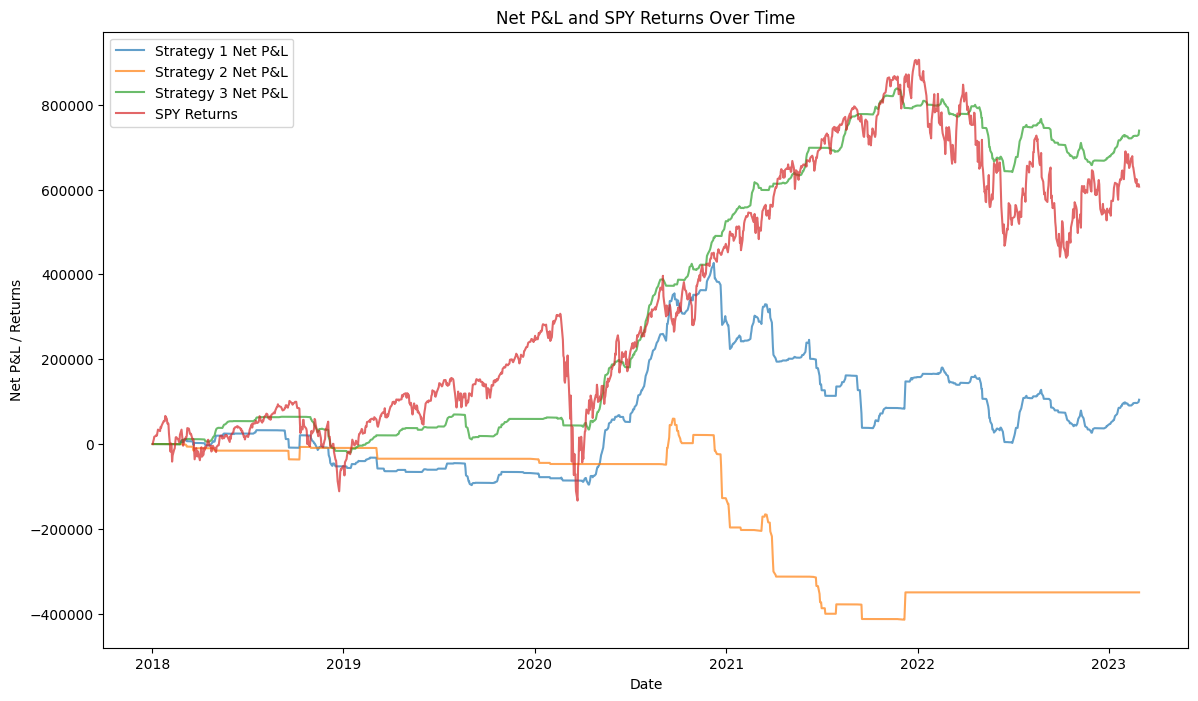

In [188]:
plot_cum_net_pl_and_spy_returns(combined_1, combined_2, combined_3, spydata)

The plot above compares the returns for all 3 trading strategies along with excess returns on SPY on a $1,000,000 initial capital. 

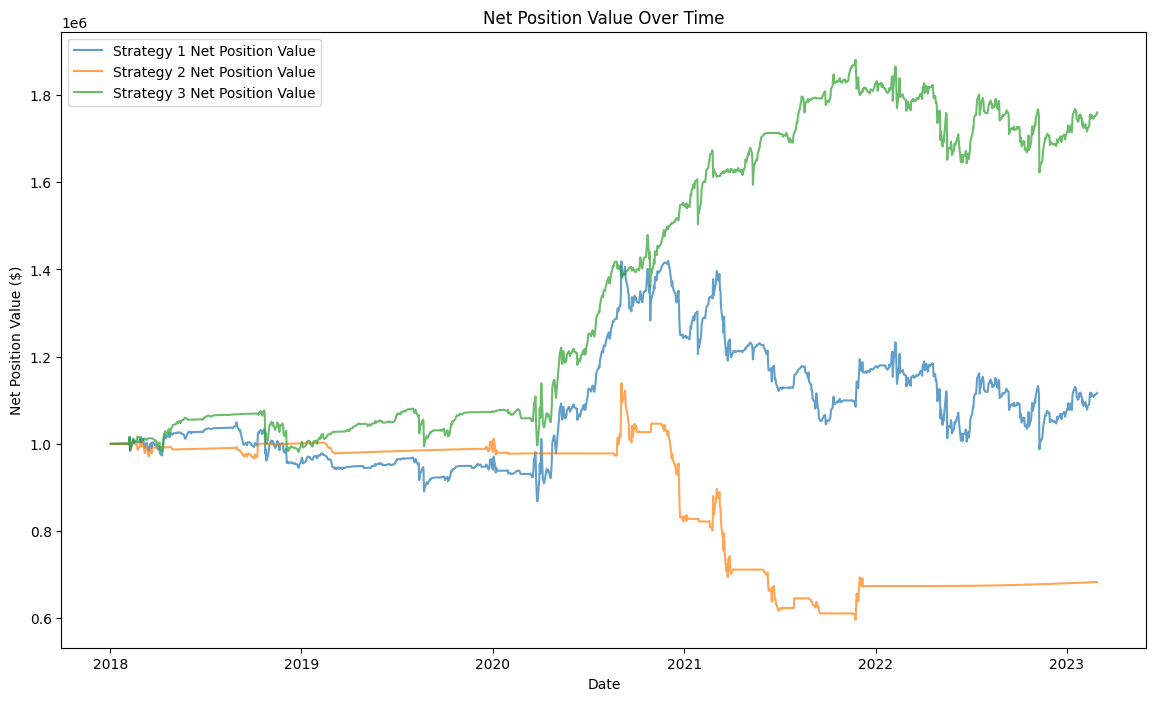

In [151]:
plot_net_pos_val(combined_1, combined_2, combined_3)

The plot above displays the net position value over time for the 3 different trading strategies. Strategy 1 shows stability until early 2020, after which there's a rapid increase, peaking around mid-2021 / 2022 before it enters a period of volatility and slight decline, yet it remains significantly above its starting value. Strategy 2 maintains a relatively flat line with slight variations, indicating stability but minimal growth, followed by a steep decline towards the end of 2020, bottoming out and remaining flat. Strategy 3 experiences gradual growth until it peaks in early 2022, experiencing volatility towards the end.